In [1]:
import re
from pathlib import Path

import pandas as pd
from am_notebooks import *

from source.utils.associate import POLAR_DIR, TOP_AM_DIR
from source.utils.associate import adjust_am_names as adjust_assoc_columns
from source.utils.dataframes import Timer
from source.utils.dataframes import enhance_descrip as e_describe
from source.utils.general import HIT_TABLES_DIR, RESULT_DIR, timestamp_today
from source.utils.sample import sample_pickle
TAG = 'ALL'
ENV_DIRS = [
    HIT_TABLES_DIR / d  for d in ('RBdirect', 'not-RBdirect', 'NEGmirror', 'POSmirror')]
NEG_DIRECT, POS_DIRECT, NEG_MIRROR, POS_MIRROR = ENV_DIRS
print('\n'.join(f'({i}) {p}' for i, p in enumerate(ENV_DIRS, start=1)))

(1) /share/compling/data/sanpi/2_hit_tables/RBdirect
(2) /share/compling/data/sanpi/2_hit_tables/not-RBdirect
(3) /share/compling/data/sanpi/2_hit_tables/NEGmirror
(4) /share/compling/data/sanpi/2_hit_tables/POSmirror


In [2]:

pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option("styler.format.thousands", ',')
pd.set_option('display.max_colwidth', 80)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 300)
REGNOT=r" (n[o']t) "
# HIT_EX_COLS = ['WITH::^[bt].*lower', 'WITH::text', 'token_str']
HIT_EX_COLS = ['all_forms_lower', 'trigger_lemma', 'trigger_lower',
               'bigram_lower', 'adv_form_lower', 'adj_form_lower', 
               'text_window', 'token_str', 'category', 'pattern', 'bigram_id']
FOCUS = ['f',
         'am_p1_given2', 
         'am_p1_given2_simple',
         'am_p2_given1', 
         'am_p2_given1_simple',
         'conservative_log_ratio',
         'am_log_likelihood',
         'N', 'f1', 
        'am_odds_ratio_disc', 
        't_score', 
        'mutual_information',
          'f2', 'E11', 'unexpected_f', 
         'l1', 'l2', 'adj', 'adj_total']
abbr_FOCUS = adjust_assoc_columns(FOCUS)

## Define helper functions

In [3]:
def update_index(df, pat_name: str = None):
    neg_env_name = df.filter(like='NEG', axis=0).l1[0]
    # > will be either `NEGATED` or `NEGMIR`
    #   both are shortened to just `NEG` for the keys in their separate dataframes
    # > replace to avoid ambiguity in `key` values when combined
    #! some filtering relies on 'NEG', so have to keep that prefix
    index_update = pat_name or (
        'NEGmir' if neg_env_name.endswith('MIR') else 'NEGany')
    df.index = df.index.str.replace('NEG', index_update)
    return df


def set_col_widths(df):
    cols = df.copy().reset_index().columns
    width_dict = (
        {c: None for c in cols}
        | {c: 22 for c in cols[cols.str.contains('_id')]}
        | {c: 35 for c in cols[cols.str.contains('text')]}
        | {c: 30 for c in cols[cols.str.contains('forms')]}
        | {c: 55 for c in cols[cols.str.contains('_str')]})
    return list(width_dict.values())


def embolden(strings: pd.Series,
             bold_regex: str = None,
             mono: bool = True) -> pd.Series:
    bold_regex = re.compile(bold_regex, flags=re.I) if bold_regex else REGNOT
    if mono:
        return strings.apply(lambda x: bold_regex.sub(r' __`\1`__ ', x))
    else:
        return strings.apply(lambda x: bold_regex.sub(r' __\1__ ', x))


def show_sample(df: pd.DataFrame,
                format: str = 'grid',
                n_dec: int = 0, 
                limit_cols: bool = True, 
                assoc: bool = False):
    _df = df.copy().convert_dtypes()
    if limit_cols and format != 'pipe' and not assoc:
        print(_df.to_markdown(
        floatfmt=f',.{n_dec}f', intfmt=',',
        maxcolwidths=set_col_widths(_df),
        tablefmt=format
    ))
    else:
        if assoc: 
            if not bool(n_dec): 
                n_dec = 2
            _df = adjust_assoc_columns(_df)
            
        
        print(_df.to_markdown(
            floatfmt=f',.{n_dec}f', intfmt=',',
            tablefmt=format
        ))

## Load and Evaluate _Exactly_ Hits by Subset

In [4]:
def update_mir_paths(paths:dict) -> dict:
    for mir in {'POS', 'NEG'}:
        key = f'{mir}mirror'
        mir_path = paths[key]
        updated_mir_path = mir_path.with_name(f'Limited{mir}-'+mir_path.name)
        if updated_mir_path.is_file():
            paths[key] = updated_mir_path
    return paths


In [5]:
all_path_dict = {d.name: tuple(d.glob(f'ALL*{d.name}*final*parq'))[0]
             for d in ENV_DIRS}
all_path_dict
# path_dict = update_mir_paths(path_dict)
# show_sample(pd.Series(path_dict).to_frame('hits path'))
# pd.Series({d:p.relative_to(POST_PROC_DIR.parent) for d,p in path_dict.items()}).to_frame('hits path')

{'RBdirect': PosixPath('/share/compling/data/sanpi/2_hit_tables/RBdirect/ALL-RBdirect_final.parq'),
 'not-RBdirect': PosixPath('/share/compling/data/sanpi/2_hit_tables/not-RBdirect/ALL_not-RBdirect_final.parq'),
 'NEGmirror': PosixPath('/share/compling/data/sanpi/2_hit_tables/NEGmirror/ALL-NEGmirror_final.parq'),
 'POSmirror': PosixPath('/share/compling/data/sanpi/2_hit_tables/POSmirror/ALL-POSmirror_final.parq')}

In [6]:
print(pd.Series(all_path_dict, name='parq_path').to_markdown())

|              | parq_path                                                                        |
|:-------------|:---------------------------------------------------------------------------------|
| RBdirect     | /share/compling/data/sanpi/2_hit_tables/RBdirect/ALL-RBdirect_final.parq         |
| not-RBdirect | /share/compling/data/sanpi/2_hit_tables/not-RBdirect/ALL_not-RBdirect_final.parq |
| NEGmirror    | /share/compling/data/sanpi/2_hit_tables/NEGmirror/ALL-NEGmirror_final.parq       |
| POSmirror    | /share/compling/data/sanpi/2_hit_tables/POSmirror/ALL-POSmirror_final.parq       |


In [7]:
def load_exactly_hits(parq_path, columns: list = HIT_EX_COLS):
    return pd.read_parquet(
        parq_path,
        engine='pyarrow',
        columns=columns,
        filters=[('adv_form_lower', '==', 'exactly')],
    )


In [8]:
full_not_exactly = load_exactly_hits(all_path_dict['RBdirect'])

In [9]:
full_not_exactly

,all_forms_lower,trigger_lemma,trigger_lower,bigram_lower,adv_form_lower,...,text_window,token_str,category,pattern,bigram_id
hit_id,,,,,,,,,,,
apw_eng_19970128_1278_20:3-4-5,n't_exactly_ready,not,n't,exactly_ready,exactly,...,Shammy was n't exactly ready to start trotting .,Shammy was n't exactly ready to start trotting .,RBdirect,direct-adj-head,apw_eng_19970128_1278_20:4-5
apw_eng_19970308_0734_3:4-5-6,n't_exactly_famous,not,n't,exactly_famous,exactly,...,smashing Pumpkins was n't exactly famous then .,smashing Pumpkins was n't exactly famous then .,RBdirect,direct-adj-head,apw_eng_19970308_0734_3:5-6
apw_eng_19970527_0859_11:13-14-15,not_exactly_sure,not,not,exactly_sure,exactly,...,first said the u.s. was `` not exactly sure what he meant . '',White House spokesman Mike McCurry at first said the U.S. was `` not exactly...,RBdirect,direct-adj-head,apw_eng_19970527_0859_11:14-15
apw_eng_19970424_1105_2:3-4-5,not_exactly_nervous,not,not,exactly_nervous,exactly,...,"well , not exactly nervous .","well , not exactly nervous .",RBdirect,direct-neg-head,apw_eng_19970424_1105_2:4-5
apw_eng_19970814_1256_15:12-13-14,not_exactly_famous,not,not,exactly_famous,exactly,...,_ all former communists _ are not exactly famous for swift organization .,but Poland 's ruling politicians _ all former communists _ are not exactly f...,RBdirect,direct-adj-head,apw_eng_19970814_1256_15:13-14
...,...,...,...,...,...,...,...,...,...,...,...
pcc_eng_val_3.06330_x44770_50:5-6-7,n't_exactly_quiet,not,n't,exactly_quiet,exactly,...,""" my neighborhood is n't exactly quiet at night ( and my dog",""" My neighborhood is n't exactly quiet at night ( and my dog snores ) , so I...",RBdirect,direct-adj-head,pcc_eng_val_3.06330_x44770_50:6-7
pcc_eng_val_3.05704_x43769_07:23-24-25,n't_exactly_revolutionary,not,n't,exactly_revolutionary,exactly,...,news for a niche audience was n't exactly revolutionary .,"The Huffington Post brought aggregation to the masses , the idea of culling ...",RBdirect,direct-adj-head,pcc_eng_val_3.05704_x43769_07:24-25
pcc_eng_val_3.00087_x34668_27:3-4-5,not_exactly_clear,not,not,exactly_clear,exactly,...,i 'm not exactly clear on bennett 's romantic standing at,"I 'm not exactly clear on Bennett 's romantic standing at this point , but I...",RBdirect,direct-adj-head,pcc_eng_val_3.00087_x34668_27:4-5


In [10]:
pmir_exactly = load_exactly_hits(all_path_dict['POSmirror'])
nmir_exactly = load_exactly_hits(all_path_dict['NEGmirror'])
# full_not_exactly = load_exactly_hits(pkl_path=path_dict['RBdirect'])

### `NEGmirror` *exactly* hits

In [11]:
xnmir = (nmir_exactly.sample(8)
            .sort_values('all_forms_lower')
            .filter(regex=r'trig[ger]*_[dl]e|text|bigram_lower'))
show_sample(xnmir)
xnmir

+------------------------+-----------------+-----------------------+------------------------------------+
| hit_id                 | trigger_lemma   | bigram_lower          | text_window                        |
+========================+=================+=======================+====================================+
| nyt_eng_19951127_0334_ | neither         | exactly_sure          | in the sense that neither of us is |
| 3:14-18-19             |                 |                       | exactly sure what the project is   |
+------------------------+-----------------+-----------------------+------------------------------------+
| pcc_eng_10_051.9405_x0 | neither         | exactly_user-friendly | neither was exactly user-friendly  |
| 823970_073:1-3-4       |                 |                       | nor offered much light .           |
+------------------------+-----------------+-----------------------+------------------------------------+
| pcc_eng_14_042.4456_x0 | never           | e

,trigger_lemma,bigram_lower,text_window
hit_id,,,
nyt_eng_19951127_0334_3:14-18-19,neither,exactly_sure,in the sense that neither of us is exactly sure what the project is
pcc_eng_10_051.9405_x0823970_073:1-3-4,neither,exactly_user-friendly,neither was exactly user-friendly nor offered much light .
pcc_eng_14_042.4456_x0669605_092:6-7-8,never,exactly_obvious,"well , the case was never exactly obvious ."
pcc_eng_23_037.7059_x0593138_04:4-6-7,never,exactly_simpatico,Ken Bates has never been exactly simpatico .
pcc_eng_10_048.8862_x0774493_08:4-5-6,never,exactly_spectacular,"my productivity , never exactly spectacular , dwindles to the merest dribble"
pcc_eng_22_015.6841_x0236826_11:1-3-4,nobody,exactly_sure,nobody is exactly sure how many people have left the
pcc_eng_15_026.9576_x0419493_10:08-15-16,none,exactly_young,the system is that none of King Abdullah 's brothers are exactly young and f...
pcc_eng_20_033.6389_x0527732_10:01-17-18,nor,exactly_sure,"Nor , it seems ( according to material released by the Crown ) , were they e..."


### `POSmirror` *exactly* hits

In [12]:
xpm = (pmir_exactly.sample(6)
            .sort_values(['all_forms_lower'])
            .filter(regex=r'trig[ger]*_[dl]e|text|bigram_lower'))
show_sample(xpm)
xpm

+------------------------+-----------------+-----------------+------------------------------------+
| hit_id                 | trigger_lemma   | bigram_lower    | text_window                        |
+========================+=================+=================+====================================+
| pcc_eng_17_104.6794_x1 | all             | exactly_alike   | may be seen , they are all exactly |
| 676013_18:23-24-25     |                 |                 | alike ( ! ) :                      |
+------------------------+-----------------+-----------------+------------------------------------+
| pcc_eng_01_101.9331_x1 | always          | exactly_correct | , is and always has been , exactly |
| 631287_13:36-40-41     |                 |                 | correct "                          |
+------------------------+-----------------+-----------------+------------------------------------+
| pcc_eng_03_019.3127_x0 | always          | exactly_right   | their heads - the church is always |


,trigger_lemma,bigram_lower,text_window
hit_id,,,
pcc_eng_17_104.6794_x1676013_18:23-24-25,all,exactly_alike,"may be seen , they are all exactly alike ( ! ) :"
pcc_eng_01_101.9331_x1631287_13:36-40-41,always,exactly_correct,", is and always has been , exactly correct """
pcc_eng_03_019.3127_x0296060_12:12-13-14,always,exactly_right,their heads - the church is always exactly right .
pcc_eng_14_047.8465_x0756834_55:4-5-6,both,exactly_right,Representative Murphy is both exactly right and spectacularly wrong .
pcc_eng_08_106.0266_x1700594_12:1-2-3,everything,exactly_same,"everything exactly same , minimum 290 people dead ."
pcc_eng_23_003.9391_x0047296_07:15-19-20,many,exactly_right,"English character actors , many of whom are exactly right for the roles they"


### ANY direct negation: *exactly* hits

In [13]:
xn_all =(full_not_exactly.sample(6)
            .sort_values(['all_forms_lower'])
            .filter(regex=r'trig[ger]*_[dl]e|text|bigram_lower'))
show_sample(xn_all)
xn_all

+------------------------+-----------------+------------------+-------------------------------------+
| hit_id                 | trigger_lemma   | bigram_lower     | text_window                         |
+========================+=================+==================+=====================================+
| pcc_eng_09_089.9773_x1 | not             | exactly_double   | one child , the amount is n't       |
| 439683_40:18-19-20     |                 |                  | exactly double .                    |
+------------------------+-----------------+------------------+-------------------------------------+
| pcc_eng_00_003.7305_x0 | not             | exactly_ideal    | profit to the federal government is |
| 044119_43:17-18-19     |                 |                  | n't exactly ideal from a business   |
|                        |                 |                  | perspective .                       |
+------------------------+-----------------+------------------+-------------------

,trigger_lemma,bigram_lower,text_window
hit_id,,,
pcc_eng_09_089.9773_x1439683_40:18-19-20,not,exactly_double,"one child , the amount is n't exactly double ."
pcc_eng_00_003.7305_x0044119_43:17-18-19,not,exactly_ideal,profit to the federal government is n't exactly ideal from a business perspe...
pcc_eng_10_075.1866_x1199028_04:28-29-30,not,exactly_radical,point out that the rule is n't exactly radical .
pcc_eng_06_105.1533_x1684938_095:3-5-6,not,exactly_discreet,you have nit been exactly discreet with your long glances .
pcc_eng_28_046.6315_x0738475_21:10-11-12,not,exactly_new,by st brendan the navigator was not exactly new .
pcc_eng_28_071.6726_x1143360_16:09-10-11,not,exactly_silent,", the climate- change movement was not exactly silent during recent history ."


In [14]:
def adjust_hit_table(_df): 
    _df.columns = _df.columns.str.replace(
        r'mir|neg', 'trig', regex=True)
    if 'all_forms_lower' not in _df.columns:
        _df = _df.assign(
            all_forms_lower=(_df.trig_form_lower.astype('string')
                            + '_' + _df.bigram_lower.astype('string')
                            ).astype('category'))
    _df = _df.drop_duplicates(['all_forms_lower', 'text_window'])

    if any(_df.category.str.contains('mirror')):
        _df['trigger_head'] = (
            _df.pattern.astype('string')
            .str.split('mirror-').str.get(1)
        ).astype('category')
    else:
        _df['trigger_head'] = (
            _df.pattern.astype('string')
            .str.split('-').str.get(1)
            .str.replace('adj', 'R')
            .str.replace('neg', 'L')
        ).astype('category')
    # if 'trigger_lower' in _df.columns: 
    #     _df = _df.loc[:, _df.columns != 'trig_form_lower']
    # else: 
    #     _df = _df.rename(columns={'trig_form_lower': 'trigger_lower'})
    return _df.rename(columns={'trig_lemma': 'trigger_lemma'})
    

In [15]:
nmir_exactly = adjust_hit_table(nmir_exactly)
pmir_exactly = adjust_hit_table(pmir_exactly)
full_not_exactly = adjust_hit_table(full_not_exactly)

/tmp/ipykernel_4466/3758346269.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['trigger_head'] = (
/tmp/ipykernel_4466/3758346269.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['trigger_head'] = (


filtering `not_exactly` hits to ignore duplicates with NEGmirror hits...

🤔 but the question is how much of the remainder is due a trigger not included in the NEGmirror patterns 
as opposed to being a duplicate that was not discarded? 

The forms `"not"` and `"n't"` were not included in the mirror hits, but are any other trigger hits cases of duplication already removed from the NEGmirror hits? 

❓ Can proper redundancy elimination only be done with the NEGmirror hits before additional duplicate removal?

In [16]:
not_exactly = full_not_exactly.copy()
not_exactly = not_exactly.loc[~not_exactly.bigram_id.isin(nmir_exactly.bigram_id), :]
xnot_exactly = (pd.Series({'all negated  hits': len(full_not_exactly), 
                       'NEGmirror complement': len(not_exactly), 
                       'NEGmirror hits': len(nmir_exactly), 
                       'POSmirror hits': len(pmir_exactly)}).to_frame('"exactly" hits in subset'))
show_sample(xnot_exactly, format='pipe')
xnot_exactly

|                      |   "exactly" hits in subset |
|:---------------------|---------------------------:|
| all negated  hits    |                     12,302 |
| NEGmirror complement |                     12,158 |
| NEGmirror hits       |                        461 |
| POSmirror hits       |                         81 |


,"""exactly"" hits in subset"
all negated hits,12302
NEGmirror complement,12158
NEGmirror hits,461
POSmirror hits,81


Ok, so not so bad, all things considered. 
- _never_, _neither_, _none_, and _nor_ should be included in the `NEGmirror` hits, but these numbers are reasonable
- **but** keep in mind that the _not_ hits shown here have not been filtered for additional duplicates

In [17]:
show_sample(not_exactly.trigger_lemma.value_counts().to_frame(), format='pipe')
not_exactly.trigger_lemma.value_counts().to_frame()

| trigger_lemma   |   count |
|:----------------|--------:|
| not             |  12,050 |
| never           |      30 |
| ain't           |      19 |
| none            |      18 |
| nothing         |      10 |
| neither         |       9 |
| nobody          |       6 |
| no              |       6 |
| nor             |       4 |
| aint            |       2 |
| without         |       2 |
| few             |       2 |


,count
trigger_lemma,
not,12050
never,30
ain't,19
none,18
nothing,10
neither,9
nobody,6
no,6
nor,4


Just going to drop the hits that should be represented by `NEGmirror`

In [18]:
neg_overlap = not_exactly.loc[not_exactly.trigger_lemma.isin(['never', 'neither', 'none', 'nor'])].filter(regex=r'all|text|token|deprel|head')
show_sample(neg_overlap)
neg_overlap

+------------------------+---------------------------+-------------------------------------+---------------------------------------------------------+----------------+
| hit_id                 | all_forms_lower           | text_window                         | token_str                                               | trigger_head   |
+========================+===========================+=====================================+=========================================================+================+
| apw_eng_20090608_0905_ | never_exactly_sure        | `` you 're never exactly sure how   | `` You 're never exactly sure how you 're going to play | R              |
| 5:4-5-6                |                           | you 're going to play               | and how confident you 're going to be first match on    |                |
|                        |                           |                                     | grass .                                                 |          

,all_forms_lower,text_window,token_str,trigger_head
hit_id,,,,
apw_eng_20090608_0905_5:4-5-6,never_exactly_sure,`` you 're never exactly sure how you 're going to play,`` You 're never exactly sure how you 're going to play and how confident yo...,R
nyt_eng_19990815_0060_18:3-5-6,never_exactly_proud,but have never been exactly proud of .,but have never been exactly proud of .,R
nyt_eng_19990119_0165_27:1-2-3,never_exactly_famous,never exactly famous for taking benign views of his,"never exactly famous for taking benign views of his subjects , Mamet startle...",R
nyt_eng_19990209_0010_40:11-12-13,never_exactly_light,criticism sonju endured _ i was never exactly light in that department mysel...,and for all the criticism Sonju endured _ I was never exactly light in that ...,R
nyt_eng_20051126_0075_14:19-21-22,none_exactly_low-income,", or liheap , though none was exactly low-income .",all were applying for help through the Low Income Home Energy Assistance Pro...,R
...,...,...,...,...
pcc_eng_28_026.7667_x0416080_02:08-10-11,never_exactly_easy,old lozen 's life has never been exactly easy .,Seventeen year old Lozen 's life has never been exactly easy .,R
pcc_eng_29_082.6208_x1318232_19:14-16-17,never_exactly_clear,"things , even if we never are exactly clear on his motives .","In his way , the doctor provides these things , even if we never are exactly...",R
pcc_eng_29_090.0488_x1438337_14:1-8-9,none_exactly_superhuman,"none of doc savage 's abilities were exactly superhuman , but they might as ...","None of Doc Savage 's abilities were exactly superhuman , but they might as ...",R


In [19]:
# nmir_overlap = nmir_exactly.loc[nmir_exactly.text_window.isin(neg_overlap.text_window)].filter(regex=r'all|text|token|deprel|head')
# show_sample(nmir_overlap)
# nmir_overlap

# > This no longer matches any rows

💡 hmm maybe the `dep` dependency relations were excluded outright for mirror patterns? (since they were developed later?)

In [20]:
# not_exactly = not_exactly.loc[~not_exactly.index.isin(neg_overlap.index),:]

In [21]:
show_sample(not_exactly.trigger_lemma.value_counts(), format='pipe')

| trigger_lemma   |   count |
|:----------------|--------:|
| not             |  12,050 |
| never           |      30 |
| ain't           |      19 |
| none            |      18 |
| nothing         |      10 |
| neither         |       9 |
| nobody          |       6 |
| no              |       6 |
| nor             |       4 |
| aint            |       2 |
| without         |       2 |
| few             |       2 |


It appears there are no duplicates in the `RBdirect` remainder however 🤷‍♀️, so I guess there just really are **that** many hits with sentential negation 🤯

In [22]:
not_exactly.text_window.duplicated().value_counts().to_frame()

,count
text_window,
False,12158


In [23]:
print(f'{not_exactly.text_window.nunique():,} unique `text_window` strings')
print(f'{len(not_exactly):,} total rows')

12,158 unique `text_window` strings
12,158 total rows


In [24]:
updated_afl = not_exactly.groupby('trigger_lemma').value_counts(['adj_form_lower'])
updated_afl.nlargest(20).to_frame()


count
trigger_lemma adj_form_lower       
not           sure             2475
              clear             469
              new               395
              true              330
              easy              292
              cheap             212
              right             163
              ideal             133
              happy             114
              surprising        107
              accurate           98
              great              80
              perfect            79
              good               78
              subtle             75
              fair               72
              fun                67
              correct            66
              thrilled           61
              healthy            59

In [25]:
updated_afl.nsmallest(10).to_frame()

count
trigger_lemma adj_form_lower       
ain't         sensible            1
              real                1
              legal               1
              free                1
              eager               1
              catchy              1
aint          easy                1
              positive            1
few           solvable            1
              woeful              1

In [26]:
not_exactly[['trigger_head', 'trigger_lemma',  'adj_form_lower']].astype('string').value_counts(['trigger_lemma', 'adj_form_lower']).nlargest(20)

trigger_lemma  adj_form_lower
not            sure              2475
               clear              469
               new                395
               true               330
               easy               292
               cheap              212
               right              163
               ideal              133
               happy              114
               surprising         107
               accurate            98
               great               80
               perfect             79
               good                78
               subtle              75
               fair                72
               fun                 67
               correct             66
               thrilled            61
               healthy             59
Name: count, dtype: int64

In [27]:
# full_not_exactly.loc[full_not_exactly.trigger_lemma!='not', ['trigger_lemma', 'adj_form_lower', 'trigger_head']].groupby('trigger_lemma').value_counts(['trigger_head','adj_form_lower', ])
trigger_counts = full_not_exactly[['trigger_lemma' ,'trigger_head', 'trigger_lower']].value_counts().to_frame().reset_index()
# trigger_counts = full_not_exactly[['trigger_lemma', 'trigger_lower' ,'trigger_head', ]].value_counts().to_frame().reset_index()
trigger_counts.index = trigger_counts.index + 1
print(trigger_counts.sort_values(['trigger_head', 'count', 'trigger_lemma'], ascending = False).to_markdown(index=False, intfmt=','))


| trigger_lemma   | trigger_head   | trigger_lower   |   count |
|:----------------|:---------------|:----------------|--------:|
| not             | R              | not             |   7,200 |
| not             | R              | n't             |   4,795 |
| never           | R              | never           |      93 |
| none            | R              | none            |      50 |
| neither         | R              | neither         |      20 |
| nobody          | R              | nobody          |      19 |
| ain't           | R              | ain't           |      19 |
| nor             | R              | nor             |      17 |
| no              | R              | no              |       8 |
| nothing         | R              | nothing         |       6 |
| not             | R              | nit             |       4 |
| without         | R              | without         |       2 |
| aint            | R              | aint            |       2 |
| few             | R    

In [28]:
def flatten_by_head(trigger_counts):
    by_head = {h: hc.filter(['trigger_lemma', 'count']).set_index('trigger_lemma')
               for h, hc in trigger_counts.groupby('trigger_head')}
    by_head = by_head['R'].join(
        by_head['L'], lsuffix='_R_headed', rsuffix='_L_headed'
    ).fillna(0).convert_dtypes().sort_index(axis=1)
    by_head.columns = by_head.columns.str.replace('count_', '')
    print(by_head.sort_values('R_headed', ascending=False).to_markdown(
        floatfmt=',.0f', intfmt=','))
    return by_head.sort_values('R_headed', ascending=False)


flatten_by_head(trigger_counts)

| trigger_lemma   |   L_headed |   R_headed |
|:----------------|-----------:|-----------:|
| not             |         51 |      7,200 |
| not             |         51 |      4,795 |
| never           |          0 |         93 |
| none            |          4 |         50 |
| neither         |          0 |         20 |
| nobody          |          0 |         19 |
| ain't           |          0 |         19 |
| nor             |          0 |         17 |
| no              |          0 |          8 |
| nothing         |         10 |          6 |
| not             |         51 |          4 |
| aint            |          0 |          2 |
| without         |          0 |          2 |
| few             |          0 |          1 |
| few             |          0 |          1 |


/tmp/ipykernel_4466/2466203865.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for h, hc in trigger_counts.groupby('trigger_head')}


,L_headed,R_headed
trigger_lemma,,
not,51,7200
not,51,4795
never,0,93
none,4,50
neither,0,20
nobody,0,19
ain't,0,19
nor,0,17
no,0,8


In [30]:
# ref_trigger_count =  pd.read_pickle(path_dict['RBdirect'])[['neg_lemma', 'pattern']].value_counts().to_frame().reset_index()
# ref_trigger_count.columns = ['trigger_lemma', 'trigger_head', 'total count']
# ref_trigger_count.index = ref_trigger_count.index + 1
# ref_trigger_count.loc[:,'trigger_head'] = ref_trigger_count.trigger_head.apply(lambda n: 'R' if 'adj' in n else 'L')

# # ref_trigger_count = pd.read_csv('/home/arh234/projects/sanpi/info/md_import_tables/allMIN-7_neg_trigger_counts.csv').set_index('rank')
# show_sample(ref_trigger_count.sort_values(['trigger_head', 'count', 'trigger_lemma'], ascending = False), format='pipe')
# flatten_by_head(ref_trigger_count)
# # show_sample(ref_trigger_count.sort_values(['trigger_lemma', 'trigger_head', 'total count'], ascending = False), format='pipe')

NameError: name 'path_dict' is not defined

`NEGmirror` *exactly* examples

In [ ]:
show_sample(nmir_exactly.sample(8)
            .sort_values(['trigger_lemma', 'trigger_lower', 'adj_form_lower'])
            .filter(regex=r'trig[ger]*_[dl]e|text|bigram_lower'))


+------------------------+-----------------+-----------------------+-------------------------------------+
| hit_id                 | trigger_lemma   | bigram_lower          | text_window                         |
+========================+=================+=======================+=====================================+
| pcc_eng_26_006.6279_x0 | neither         | exactly_tolerant      | for trump and clinton , neither are |
| 090739_17:13-15-16     |                 |                       | exactly tolerant of free speech .   |
+------------------------+-----------------+-----------------------+-------------------------------------+
| apw_eng_20020724_0578_ | never           | exactly_buoyant       | of spanish-moroccan relations which |
| 11:13-14-15            |                 |                       | , while never exactly buoyant , had |
|                        |                 |                       | plunged in recent years             |
+------------------------+-----------

`POSmirror` *exactly* examples

In [ ]:
show_sample(pmir_exactly.sample(8)
            .sort_values(['trigger_lemma', 'trigger_lower', 'adj_form_lower'])
            .filter(regex=r'trig[ger]*_[dl]e|text|bigram_lower'))


+------------------------+-----------------+-------------------+-------------------------------------+
| hit_id                 | trigger_lemma   | bigram_lower      | text_window                         |
+========================+=================+===================+=====================================+
| pcc_eng_29_041.8913_x0 | all             | exactly_alike     | of the man whose teeth were all     |
| 660527_20:09-10-11     |                 |                   | exactly alike i have is hardcover , |
|                        |                 |                   | published                           |
+------------------------+-----------------+-------------------+-------------------------------------+
| pcc_eng_24_046.2031_x0 | all             | exactly_alike     | is the man whose teeth were all     |
| 730651_07:25-26-27     |                 |                   | exactly alike ( henceforth teeth )  |
|                        |                 |                   | .       

Sententially negated *exactly* examples

In [ ]:
show_sample(not_exactly.sample(8)
            .sort_values(['trigger_lemma', 'trigger_lower', 'adj_form_lower'])
            .filter(regex=r'trig[ger]*_[dl]e|text|bigram_lower'))

+------------------------+-----------------+-------------------+-------------------------------------+
| hit_id                 | trigger_lemma   | bigram_lower      | text_window                         |
+========================+=================+===================+=====================================+
| pcc_eng_06_028.6676_x0 | not             | exactly_close     | the patriots were n't exactly close |
| 447527_02:4-5-6        |                 |                   | to drafting wide receiver dez       |
|                        |                 |                   | bryant                              |
+------------------------+-----------------+-------------------+-------------------------------------+
| pcc_eng_10_024.6896_x0 | not             | exactly_perfect   | sure , the united states is n't     |
| 382762_11:7-8-9        |                 |                   | exactly perfect when it comes to    |
|                        |                 |                   | allowing

In [ ]:
all_pat_counts = pd.concat((mdf.pattern.value_counts() for mdf in [pmir_exactly, nmir_exactly, not_exactly])
                           ).to_frame().sort_values('count', ascending=False)
show_sample(all_pat_counts, format='pipe')
all_pat_counts

| pattern         |   count |
|:----------------|--------:|
| direct-adj-head |  12,113 |
| neg-mirror-R    |     438 |
| pos-mirror-R    |      78 |
| direct-neg-head |      61 |
| neg-mirror-L    |      23 |
| pos-mirror-L    |       3 |


,count
pattern,
direct-adj-head,12113
neg-mirror-R,438
pos-mirror-R,78
direct-neg-head,61
neg-mirror-L,23
pos-mirror-L,3


In [ ]:
all_trig_counts = pd.concat((mdf.trigger_head for mdf in [pmir_exactly, nmir_exactly, not_exactly])).value_counts().to_frame()
show_sample(all_trig_counts, format='pipe')
all_trig_counts

| trigger_head   |   count |
|:---------------|--------:|
| R              |  12,629 |
| L              |      87 |


,count
trigger_head,
R,12629
L,87


In [ ]:
exactly = pd.concat((d[['adj_form_lower', 'trigger_head', 'trigger_lemma',  'category']].astype('string') 
           for d in [not_exactly, nmir_exactly, pmir_exactly])
          )
exactly

,adj_form_lower,trigger_head,trigger_lemma,category
hit_id,,,,
apw_eng_19970128_1278_20:3-4-5,ready,R,not,RBdirect
apw_eng_19970308_0734_3:4-5-6,famous,R,not,RBdirect
apw_eng_19970527_0859_11:13-14-15,sure,R,not,RBdirect
apw_eng_19970424_1105_2:3-4-5,nervous,L,not,RBdirect
apw_eng_19970814_1256_15:12-13-14,famous,R,not,RBdirect
...,...,...,...,...
pcc_eng_29_002.8566_x0029958_0469:12-13-14,alike,R,all,POSmirror
pcc_eng_29_041.8913_x0660527_01:6-7-8,alike,R,all,POSmirror
pcc_eng_29_046.5934_x0736252_76:1-5-6,right,R,all,POSmirror


In [ ]:
for trigger, tdf in exactly.groupby('trigger_lemma'):
    print(f'\n>> {trigger} <<')
    show_sample(tdf.groupby('trigger_head').adj_form_lower.value_counts().nlargest(10).reset_index(), format='pipe')


>> ain't <<
|    | trigger_head   | adj_form_lower   |   count |
|---:|:---------------|:-----------------|--------:|
|  0 | R              | clear            |      11 |
|  1 | R              | easy             |       2 |
|  2 | R              | catchy           |       1 |
|  3 | R              | eager            |       1 |
|  4 | R              | free             |       1 |
|  5 | R              | legal            |       1 |
|  6 | R              | real             |       1 |
|  7 | R              | sensible         |       1 |

>> aint <<
|    | trigger_head   | adj_form_lower   |   count |
|---:|:---------------|:-----------------|--------:|
|  0 | R              | easy             |       1 |
|  1 | R              | positive         |       1 |

>> all <<
|    | trigger_head   | adj_form_lower   |   count |
|---:|:---------------|:-----------------|--------:|
|  0 | R              | alike            |      19 |
|  1 | R              | right            |       7 |
|  2 | R  

---
## *Exactly* Associations
### Work in Progress 🚧 

_Prior_ Table Output for Negation Marginal frequencies

|                     |        `N` |      `f1` |   `adv_total` |
|:--------------------|-----------:|----------:|--------------:|
| **NEGATED_exactly** | 86,330,752 | 3,226,213 |        61,599 |
| **NEGMIR_exactly**  |  2,032,082 |   293,963 |         1,114 |

### Top bigrams for _exactly_

####  Strongest NEGATIVE _Environment_ Association

In [ ]:
# FOCUS = ['polarity','f',
#          'am_p1_given2', 'am_p2_given1', 
#          'deltaP_max', 'deltaP_mean', 
#          'am_p1_given2_simple', 'am_p2_given1_simple',
#          'conservative_log_ratio', 'am_log_likelihood',
#         #  'mutual_information', 'am_odds_ratio_disc', 't_score',
#          'N', 'f1', 'f2', 'E11', 'unexpected_f', 
#          'l1', 'l2', 'adj', 'adj_total']
FOCUS=FOCUS_DICT[TAG]['polar']

In [ ]:
exactly_most_neg_csv = None
date_flag = timestamp_today()
if any(set(TOP_AM_DIR.rglob(f'{TAG}*exactly*NEG*csv'))): 
    while exactly_most_neg_csv is None: 
        try:
            exactly_most_neg_csv = tuple(TOP_AM_DIR.rglob(f'{TAG}/*/*exactly_*mostNEG-bigrams_AMscores*{date_flag}.csv'))[0]
        except IndexError:
            date_flag = day_before(date_flag)
else:
    raise FileNotFoundError(f'🛑 No AM processing specific to "{TAG}" & "exactly" can be found. Return to general notebooks.')
        
! du -h --time {exactly_most_neg_csv}


FileNotFoundError: 🛑 No AM processing specific to "ALL" & "exactly" can be found. Return to general notebooks.

In [ ]:
most_neg = pd.read_csv(exactly_most_neg_csv, index_col='key')
most_neg = most_neg.assign(dP1_simple=most_neg.f/most_neg.f2)
show_sample(most_neg.sort_values(['LRC', 'dP1'], ascending=False).filter(adjust_assoc_columns(FOCUS)), assoc=True, format='pipe')

| key                        |     f |   dP1 |   LRC |        G2 |          N |        f1 |    f2 |
|:---------------------------|------:|------:|------:|----------:|-----------:|----------:|------:|
| NEGany~exactly_sure        | 8,860 |  0.92 |  8.63 | 54,750.58 | 86,330,752 | 3,226,213 | 9,301 |
| NEGany~exactly_new         | 1,378 |  0.93 |  8.54 |  8,697.93 | 86,330,752 | 3,226,213 | 1,418 |
| NEGany~exactly_easy        | 1,069 |  0.93 |  8.37 |  6,747.64 | 86,330,752 | 3,226,213 | 1,100 |
| NEGany~exactly_clear       | 1,759 |  0.92 |  8.30 | 10,937.16 | 86,330,752 | 3,226,213 | 1,835 |
| NEGany~exactly_cheap       |   693 |  0.95 |  8.28 |  4,443.27 | 86,330,752 | 3,226,213 |   704 |
| NEGany~exactly_surprising  |   441 |  0.96 |  7.34 |  2,863.35 | 86,330,752 | 3,226,213 |   444 |
| NEGany~exactly_practical   |   105 |  0.95 |  3.52 |    679.01 | 86,330,752 | 3,226,213 |   106 |
| NEGmir~exactly_clear       |    52 |  0.80 |  2.13 |    178.73 |  2,032,082 |   293,963 |    55 |
| NEGmir~exactly_sure        |   148 |  0.85 |  2.09 |    560.65 |  2,032,082 |   293,963 |   149 |
| NEGany~exactly_shy         |   124 |  0.96 |  1.53 |    815.15 | 86,330,752 | 3,226,213 |   124 |
| NEGany~exactly_forthcoming |   107 |  0.96 |  1.32 |    703.40 | 86,330,752 | 3,226,213 |   107 |
| NEGany~exactly_impressive  |   100 |  0.96 |  1.22 |    657.38 | 86,330,752 | 3,226,213 |   100 |


#### Strongest INTERNAL _Context-Blind_ Association

In [ ]:
top_overall = pd.read_csv('/share/compling/projects/sanpi/results/top_AM/any_bigram_examples/exactly/exactly_top11-bigrams_AMscores_2024-05-18.csv', index_col='key')
top_overall.sort_values('LRC', ascending=False)

,f,exp_f,unexp_f,dP1,LRC,...,N,f1,f2,l1,l2
key,,,,,,,,,,,
exactly~alike,3040,9.46,"3,030.54",0.23,8.55,...,86330753,61599,13261,exactly,alike
exactly~opposite,498,6.71,491.29,0.05,5.94,...,86330753,61599,9404,exactly,opposite
exactly~right,6948,145.97,"6,802.03",0.03,5.53,...,86330753,61599,204572,exactly,right
exactly~zero,344,8.19,335.81,0.03,5.02,...,86330753,61599,11472,exactly,zero
exactly~parallel,224,5.41,218.59,0.03,4.90,...,86330753,61599,7577,exactly,parallel
exactly~sure,9301,602.91,"8,698.09",0.01,3.89,...,86330753,61599,844981,exactly,sure
exactly~equal,560,33.61,526.39,0.01,3.75,...,86330753,61599,47099,exactly,equal
exactly~conducive,214,11.71,202.29,0.01,3.68,...,86330753,61599,16405,exactly,conducive
exactly~correct,788,55.83,732.17,0.01,3.56,...,86330753,61599,78240,exactly,correct


### `ENV~ADJ` associations for top bigrams

In [ ]:
setdiff_floor = 200
mirror_floor = 120
adj_dfs = {
    d.name:
    update_index(pd.read_pickle(
        tuple(d.joinpath('adj/extra')
              .glob(f'*35f-7c*min{mirror_floor if d.name == "NEGmirror" else setdiff_floor}x*.pkl.gz')
              )[0]
    )
    )
    for d in POLAR_DIR.iterdir()}
for pat_dir, amdf in adj_dfs.items():
    print(f'>> {pat_dir} <<')
    show_sample(amdf.loc[amdf.conservative_log_ratio.abs().round() > 1, :].sample(
        8).filter(FOCUS).filter(regex=r'^[^l]'), assoc=True)
    print('.............')

>> RBdirect <<
+-------------------+---------+-------+-------+--------------+--------------+--------------+-------+-----------+------------+------------+---------+------------+-----------+
| key               |       f |   dP1 |   dP2 |   deltaP_max |   dP1_simple |   dP2_simple |   LRC |        G2 |          N |         f1 |      f2 |      exp_f |   unexp_f |
+===================+=========+=======+=======+==============+==============+==============+=======+===========+============+============+=========+============+===========+
| COM~rural         |  15,805 |  0.03 |  0.00 |         0.03 |         0.99 |         0.00 |  1.82 |    641.86 | 86,330,752 | 83,102,035 |  15,907 |  15,312.09 |    492.91 |
+-------------------+---------+-------+-------+--------------+--------------+--------------+-------+-----------+------------+------------+---------+------------+-----------+
| COM~smaller       |  99,868 |  0.03 |  0.00 |         0.03 |         0.99 |         0.00 |  2.32 |  4,120.67 | 86

In [ ]:
adj_amdf = pd.concat(adj_dfs.values())
adj_amdf = adjust_assoc_columns(adj_amdf)
adj_amdf = adj_amdf.sort_values(
    ['LRC', 'dP1', 'dP1_simple'],
    ascending=False)
adj_amdf.filter(abbr_FOCUS).describe().round(2).T.iloc[:,1:].sort_index()


,mean,std,min,25%,50%,75%,max
G2,24.05,"4,604.00","-188,432.85",-0.65,6.44,33.16,"188,571.60"
LRC,0.06,0.55,-5.66,0.00,0.00,0.00,5.66
MI,0.00,0.12,-1.40,-0.00,0.01,0.01,1.27
dP1,0.01,0.05,-0.76,-0.00,0.01,0.03,0.76
dP1_simple,0.82,0.33,0.00,0.90,0.97,0.98,1.00
dP2,0.00,0.00,-0.04,-0.00,0.00,0.00,0.04
dP2_simple,0.00,0.00,0.00,0.00,0.00,0.00,0.05
f,"8,481.82","55,421.21",120.00,331.00,758.00,"2,629.50","2,198,836.00"
f2,"15,931.39","80,623.04",122.00,418.00,"1,243.50","6,206.00","2,212,989.00"
odds_r_disc,0.21,0.40,-1.77,-0.05,0.17,0.43,2.39


In [ ]:
for c in adj_amdf.select_dtypes(include='number').columns:
    print(f'\nWeakest/Minimum `{c}`')
    show_sample(
        adj_amdf.loc[adj_amdf[c] == adj_amdf[c].abs().min()]
                .filter(set(abbr_FOCUS + [c])).head(10),
        assoc=True, format='pipe')


Weakest/Minimum `f`
| key               |   dP1 |     t |   dP2_simple |   odds_r_disc |   f2 |    MI | l2            |   f | l1     |    G2 |   LRC |   dP1_simple |   dP2 |
|:------------------|------:|------:|-------------:|--------------:|-----:|------:|:--------------|----:|:-------|------:|------:|-------------:|------:|
| POS~regional      |  0.12 |  1.42 |         0.00 |          0.63 |  125 |  0.06 | regional      | 120 | POSMIR | 19.20 |     0 |         0.96 |  0.00 |
| POS~psychological |  0.12 |  1.34 |         0.00 |          0.56 |  126 |  0.06 | psychological | 120 | POSMIR | 16.55 |     0 |         0.95 |  0.00 |
| POS~sexist        |  0.09 |  1.12 |         0.00 |          0.40 |  129 |  0.05 | sexist        | 120 | POSMIR | 10.34 |     0 |         0.93 |  0.00 |
| POS~unsuitable    |  0.09 |  1.04 |         0.00 |          0.35 |  130 |  0.04 | unsuitable    | 120 | POSMIR |  8.72 |     0 |         0.92 |  0.00 |
| POS~disingenuous  |  0.06 |  0.73 |         0.00 |   

In [ ]:
for c in adj_amdf.select_dtypes(include='number').columns:
    print(f'\nStrongest/Maximum `{c}`')
    show_sample(
        adj_amdf.loc[adj_amdf[c] == adj_amdf[c].max()]
                .filter(set(FOCUS + [c])).head(10),
        assoc=True, format='pipe')


Strongest/Maximum `f`
| key      |         f | l1         |        f2 |          N |         f1 |   deltaP_max | l2   |
|:---------|----------:|:-----------|----------:|-----------:|-----------:|-------------:|:-----|
| COM~many | 2,198,836 | COMPLEMENT | 2,212,989 | 86,330,752 | 83,102,035 |         0.03 | many |

Strongest/Maximum `exp_f`
| key      |         f |        exp_f | l1         |        f2 |          N |         f1 |   deltaP_max | l2   |
|:---------|----------:|-------------:|:-----------|----------:|-----------:|-----------:|-------------:|:-----|
| COM~many | 2,198,836 | 2,130,224.57 | COMPLEMENT | 2,212,989 | 86,330,752 | 83,102,035 |         0.03 | many |

Strongest/Maximum `G2`
| key        |       f |         G2 | l1      |      f2 |          N |        f1 |   deltaP_max | l2   |
|:-----------|--------:|-----------:|:--------|--------:|-----------:|----------:|-------------:|:-----|
| NEGany~bad | 105,275 | 188,571.60 | NEGATED | 557,528 | 86,330,752 | 3,226,213 | 

### significant environment LRCs for context-blind *exactly* associated adjectives

In [ ]:
show_sample(adj_amdf
            .sort_values(['f1','LRC'], ascending=False)
            .filter(abbr_FOCUS).filter(regex=r'NEGany|COM', axis=0)
            .loc[(adj_amdf.l2.isin(top_overall.l2)) & (adj_amdf.LRC>1), :],
            format='fancy_outline',
            assoc=True)

╒══════════════════╤═════════╤═══════╤══════════════╤═══════╤══════════════╤═══════╤════════════╤══════╤═══════════════╤════════╤═════════╤════════════╤═══════════╕
│ key              │       f │   dP1 │   dP1_simple │   dP2 │   dP2_simple │   LRC │         G2 │   MI │   odds_r_disc │      t │      f2 │ l1         │ l2        │
╞══════════════════╪═════════╪═══════╪══════════════╪═══════╪══════════════╪═══════╪════════════╪══════╪═══════════════╪════════╪═════════╪════════════╪═══════════╡
│ COM~same         │  55,867 │  0.03 │         0.99 │  0.00 │         0.00 │  2.31 │   2,406.02 │ 0.01 │          0.83 │   7.52 │  56,190 │ COMPLEMENT │ same      │
│ COM~zero         │  11,377 │  0.03 │         0.99 │  0.00 │         0.00 │  1.42 │     391.67 │ 0.01 │          0.67 │   3.13 │  11,472 │ COMPLEMENT │ zero      │
│ NEGany~sure      │ 128,824 │  0.12 │         0.15 │  0.03 │         0.04 │  2.19 │ 182,987.33 │ 0.61 │          0.68 │ 270.94 │ 844,981 │ NEGATED    │ sure      │
│ NEGany~c

In [ ]:
show_sample(adj_amdf
            .sort_values(['f1','LRC'], ascending=False)
            .filter(abbr_FOCUS).filter(regex=r'NEGmir|POS', axis=0)
            .loc[(adj_amdf.l2.isin(top_overall.l2)) & (adj_amdf.LRC>1), :],
            format='fancy_outline',
            assoc=True)

╒═════════════╤═══════╤═══════╤══════════════╤═══════╤══════════════╤═══════╤══════════╤══════╤═══════════════╤═══════╤═══════╤════════╤══════╕
│ key         │     f │   dP1 │   dP1_simple │   dP2 │   dP2_simple │   LRC │       G2 │   MI │   odds_r_disc │     t │    f2 │ l1     │ l2   │
╞═════════════╪═══════╪═══════╪══════════════╪═══════╪══════════════╪═══════╪══════════╪══════╪═══════════════╪═══════╪═══════╪════════╪══════╡
│ NEGmir~sure │ 5,753 │  0.43 │         0.59 │  0.02 │         0.02 │  2.72 │ 9,087.14 │ 0.56 │          0.87 │ 54.72 │ 9,744 │ NEGMIR │ sure │
╘═════════════╧═══════╧═══════╧══════════════╧═══════╧══════════════╧═══════╧══════════╧══════╧═══════════════╧═══════╧═══════╧════════╧══════╛


In [ ]:
def interpret_polar_lrc(amdf: pd.DataFrame) -> pd.DataFrame:
    if "LRC" not in amdf.columns: 
        amdf = adjust_assoc_columns(amdf)
    amdf = amdf.assign(
        polarity=amdf.l1.apply(
            lambda env: 'Negative' if env.startswith('NEG') else 'Positive'),
        significant=amdf.LRC.abs() > 1,
        attract=amdf.LRC.round() > 0)
    amdf = amdf.assign(promote=amdf.significant & amdf.attract,
                       prohibit=amdf.significant & ~amdf.attract)
    
    return amdf


In [ ]:

adj_amdf_i = interpret_polar_lrc(adj_amdf
                               .filter(abbr_FOCUS)
                               .loc[adj_amdf.l2.isin(top_overall.l2), :]
                               ).sort_values('LRC',
                                            ascending=False)


In [ ]:
pmir_conducive = sample_pickle(data=pmir_exactly, sample_size=4,
                          columns=['all_forms_lower', 'token_str'], filters=['adj_form_lower==conducive'], 
                          print_sample=False)
show_sample(pmir_conducive.assign(token_str = embolden(pmir_conducive.token_str, 
                                                          bold_regex=r' (exactly.conducive) ')))


- *filtering rows...*
  - regex parsing = False
  - Filter expression `adj_form_lower==conducive` matched zero rows. Filter not applied.

### 4 random rows from `input frame`

+------------------------+--------------------------+---------------------------------------------------------+
| hit_id                 | all_forms_lower          | token_str                                               |
+========================+==========================+=========================================================+
| pcc_eng_12_084.8670_x1 | or_exactly_opposite      | Or maybe it is exactly opposite - you are owed large    |
| 355059_03:1-5-6        |                          | refunds .                                               |
+------------------------+--------------------------+---------------------------------------------------------+
| pcc_eng_23_018.2889_x0 | everything_exactly_right | We stayed in a slip at their dock for a month , and     |
| 278946_09:25-27-28     |             

In [ ]:
nmir_conducive = sample_pickle(data=nmir_exactly, sample_size=4,
                          columns=['all_forms_lower', 'token_str'], filters=['adj_form_lower==conducive'], 
                          print_sample=False)
show_sample(nmir_conducive.assign(token_str = embolden(nmir_conducive.token_str, 
                                                          bold_regex=r' (exactly.conducive) ')), format='pipe')


- *filtering rows...*
  - regex parsing = False
  - ✓ Applied filter: `adj_form_lower==conducive`



### All (2) row(s) matching filter(s) from `input frame`

| hit_id                                | all_forms_lower        | token_str                                                                                                              |
|:--------------------------------------|:-----------------------|:-----------------------------------------------------------------------------------------------------------------------|
| pcc_eng_00_042.0217_x0662848_14:1-8-9 | none_exactly_conducive | None of these places or circumstances were __`exactly conducive`__ for a dog , so she " stayed " with my mom and dad . |
| pcc_eng_11_078.1769_x1249405_45:1-5-6 | none_exactly_conducive | None of which were __`exactly conducive`__ to climbing nice , cold mountains .                                         |


### Context-blind *exactly* associated adjectives Polarity Preferences


In [ ]:
pd.crosstab(adj_amdf_i.l1, adj_amdf_i.promote)

promote,False,True
l1,,
COMPLEMENT,9,2
NEGATED,6,4
NEGMIR,2,1
POSMIR,9,0



Of the 11 adjectives most strongly associated with _exactly_ when context is ignored: 
- only 6 show any significant polar sensitivity in the superset data,
    - 2 with a Positive lean
    - 4 with a Negative lean
- only 1 shows significant polarity sensitivity in the `mirror` subset
    - with a tendency toward negative environments

Thus, despite the overall negative propensity of *exactly*, half of the most commonly associated adjectives overall are completely neutral on their own. 
Of those that skew toward negative environments, the effect size is relatively weak, with _sure_ garnering an LRC of 2.1-2.7 and _conducive_, _correct_, and _right_ only barely surpassing 1. 

| key              |       f |   dP1 |   LRC |   dP1_simple |         G2 |      f2 |
|:-----------------|--------:|------:|------:|-------------:|-----------:|--------:|
| NEGmir~sure      |   5,753 |  0.43 |  2.72 |         0.59 |   9,087.14 |   9,744 |
| NEGany~sure      | 128,824 |  0.12 |  2.19 |         0.15 | 182,987.33 | 844,981 |
| NEGany~conducive |   1,618 |  0.06 |  1.29 |         0.10 |   1,196.28 |  16,405 |
| NEGany~correct   |   6,864 |  0.05 |  1.21 |         0.09 |   4,049.83 |  78,240 |
| NEGany~right     |  15,740 |  0.04 |  1.04 |         0.08 |   6,902.12 | 204,572 |


Even more strikingly, 2 of these adjectives even demonstrate a bias for _positive_ environments when considered independently of adverb modifier,
although these effect sizes are also quite small, and the accuracy of the parses for these particular adjectives are questionable.

| key      |      f |   dP1 |   LRC |   dP1_simple |       G2 |     f2 |
|:---------|-------:|------:|------:|-------------:|---------:|-------:|
| COM~same | 55,867 |  0.03 |  2.31 |         0.99 | 2,406.02 | 56,190 |
| COM~zero | 11,377 |  0.03 |  1.42 |         0.99 |   391.67 | 11,472 |



In [ ]:
show_sample(adj_amdf_i.filter(like='O', axis=0).loc[adj_amdf_i.promote, :'f2'], assoc=True, format='pipe')

| key      |      f |   dP1 |   dP1_simple |   dP2 |   dP2_simple |   LRC |       G2 |   MI |   odds_r_disc |    t |     f2 |
|:---------|-------:|------:|-------------:|------:|-------------:|------:|---------:|-----:|--------------:|-----:|-------:|
| COM~same | 55,867 |  0.03 |         0.99 |  0.00 |         0.00 |  2.31 | 2,406.02 | 0.01 |          0.83 | 7.52 | 56,190 |
| COM~zero | 11,377 |  0.03 |         0.99 |  0.00 |         0.00 |  1.42 |   391.67 | 0.01 |          0.67 | 3.13 | 11,472 |


#### REMEMBER: _The `env~adj` AM are for_ ALL _adverbs, not just_ "exactly"

In [ ]:

adj_amdf_i.loc[adj_amdf_i.promote, :].groupby('polarity').value_counts(['l1'])


polarity  l1        
Negative  NEGATED       4
          NEGMIR        1
Positive  COMPLEMENT    2
Name: count, dtype: int64

In [ ]:
# attract_only = adj_amdf_i.loc[adj_amdf_i.attract,:]
pd.crosstab(adj_amdf_i.polarity, adj_amdf_i.LRC.apply(lambda x: 'strong_attract' if x > 2.5 else ('weak_attract' if x > 1 else ('neutral' if x > -1 else 'repel'))))


LRC,neutral,repel,strong_attract,weak_attract
polarity,,,,
Negative,7,1,1,4
Positive,13,5,0,2


In [ ]:
for adj, adj_only_am in adj_amdf_i.groupby('l2'): 
    print(f'\n#### {adj}\n')
    show_sample(adj_only_am.filter(regex=r'^f$|^[dLGupsa]'), assoc=True, format='pipe')
    if any(adj_only_am['promote']): 
        polar_promoted = adj_only_am.loc[adj_only_am.promote, :]
        for adj_in_env in polar_promoted.index:
            lrc_val = polar_promoted.loc[adj_in_env, 'LRC'].round(3).squeeze()
            caveat = "(but weak) " if abs(lrc_val) < 2 else ''
            print(f'\n👀🧲 significant {caveat} LRC found for _{adj}_ adj & `{adj_in_env.split("~")[0]}` env: {lrc_val:.3f}\n')
        show_sample(polar_promoted[['polarity', 'f', 'LRC', 'dP1','dP1_simple']], assoc=True, format='pipe')


#### alike

| key          |      f |   dP1 |   dP1_simple |   dP2 |   dP2_simple |   LRC |     G2 | polarity   | significant   | attract   | promote   | prohibit   |
|:-------------|-------:|------:|-------------:|------:|-------------:|------:|-------:|:-----------|:--------------|:----------|:----------|:-----------|
| NEGany~alike |    698 |  0.02 |         0.05 |  0.00 |         0.00 |  0.21 |  76.53 | Negative   | False         | False     | False     | False      |
| POS~alike    |    351 | -0.02 |         0.81 | -0.00 |         0.00 |  0.00 |  -1.35 | Positive   | False         | False     | False     | False      |
| COM~alike    | 12,563 | -0.02 |         0.95 | -0.00 |         0.00 | -0.21 | -76.20 | Positive   | False         | False     | False     | False      |

#### conducive

| key              |      f |   dP1 |   dP1_simple |   dP2 |   dP2_simple |   LRC |        G2 | polarity   | significant   | attract   | promote   | prohibit   |
|:-----------------|-------:|----

### Adjectives that create the most negatively skewed bigrams when modified by *exactly*

Of the adjectives that most strongly negative bigrams when modified by _exactly_, 
- 0 are independently prone to positive polarity environments
- 5/10 are independently prone to negative environments when data superset is considered 
- 2/9[^1] are independently predisposed to negative environments when only the negative mirrors are considered

| polarity | l1         | prone | count |
|:---------|:-----------|:--------|------:|
| Negative | NEGATED    | True    |     5 |
| Negative | NEGATED    | False   |     5 |
| Negative | NEGMIR     | True    |     2 |
| Negative | NEGMIR     | False   |     7 |
| Positive | COMPLEMENT | True    |     0 |
| Positive | COMPLEMENT | False   |    10 |
| Positive | POSMIR     | True    |     0 |
| Positive | POSMIR     | False   |    10 |

[^1]: only 9 of 10 adjectives identified in the strongly negative bigram selection have an entry in the mirror subset AMs

In [ ]:
show_sample(interpret_polar_lrc(adj_amdf.loc[adj_amdf.l2.isin(most_neg.adj),:].filter(abbr_FOCUS))
            .groupby(['polarity','l1']).value_counts(['promote']).reset_index(), format='pipe')

|    | polarity   | l1         | promote   |   count |
|---:|:-----------|:-----------|:----------|--------:|
|  0 | Negative   | NEGATED    | False     |       5 |
|  1 | Negative   | NEGATED    | True      |       5 |
|  2 | Negative   | NEGMIR     | False     |       7 |
|  3 | Negative   | NEGMIR     | True      |       2 |
|  4 | Positive   | COMPLEMENT | False     |      10 |
|  5 | Positive   | POSMIR     | False     |      10 |


In [ ]:
neg_bigram_adj = interpret_polar_lrc(
    adj_amdf.loc[adj_amdf.l2.isin(most_neg.adj), :].filter(abbr_FOCUS))
show_sample(neg_bigram_adj.loc[(neg_bigram_adj.polarity == 'Negative') & (neg_bigram_adj.promote), :].value_counts(['l2'])
            .to_frame('# datasets where negatively associated').reset_index(), format='pipe')


|    | l2          |   # datasets where negatively associated |
|---:|:------------|-----------------------------------------:|
|  0 | clear       |                                        2 |
|  1 | sure        |                                        2 |
|  2 | easy        |                                        1 |
|  3 | forthcoming |                                        1 |
|  4 | surprising  |                                        1 |


In [ ]:
show_sample(neg_bigram_adj.loc[(neg_bigram_adj.polarity == 'Negative') & (~neg_bigram_adj.promote), :].value_counts(['l2'])
            .to_frame('# datasets where NOT negatively associated').reset_index(), format='pipe')

|    | l2         |   # datasets where NOT negatively associated |
|---:|:-----------|---------------------------------------------:|
|  0 | cheap      |                                            2 |
|  1 | impressive |                                            2 |
|  2 | new        |                                            2 |
|  3 | practical  |                                            2 |
|  4 | shy        |                                            2 |
|  5 | easy       |                                            1 |
|  6 | surprising |                                            1 |


In [ ]:
show_sample(neg_bigram_adj.sort_values(['l2','l1']).loc[(neg_bigram_adj.polarity=='Negative') & ~neg_bigram_adj.promote, :'f2'], format='pipe', assoc=True)

| key               |      f |   dP1 |   dP1_simple |   dP2 |   dP2_simple |   LRC |       G2 |    MI |   odds_r_disc |      t |      f2 |
|:------------------|-------:|------:|-------------:|------:|-------------:|------:|---------:|------:|--------------:|-------:|--------:|
| NEGany~cheap      |  4,121 |  0.01 |         0.05 |  0.00 |         0.00 |  0.29 |   297.40 |  0.12 |          0.12 |  15.43 |  83,765 |
| NEGmir~cheap      |    229 | -0.04 |         0.13 | -0.00 |         0.00 |  0.00 |   -22.04 | -0.12 |         -0.14 |  -4.75 |   1,829 |
| NEGmir~easy       |  5,055 |  0.09 |         0.25 |  0.01 |         0.02 |  0.65 | 1,008.11 |  0.19 |          0.24 |  24.72 |  20,050 |
| NEGany~impressive |  8,912 |  0.01 |         0.05 |  0.00 |         0.00 |  0.21 |   340.20 |  0.09 |          0.09 |  16.92 | 195,739 |
| NEGmir~impressive |    937 |  0.02 |         0.19 |  0.00 |         0.00 |  0.00 |    16.73 |  0.05 |          0.07 |   3.57 |   5,033 |
| NEGany~new        | 10,47

LRC values indicate that, while _clear_ and _sure_ show independent negative association in both datasets, _easy_ and _surprising_ show significant negative association for the superset, but not for the subset.
The adjectives _cheap_, _impressive_, _new_, _practical_, and _shy_ do not show significant negative lean neither superset nor subset.
Finally, _forthcoming_ only appears in the superset evaluation, where it demonstrates a preference for negative polarity environments.

The only adjective in this set with a $\Delta P(\texttt{env}|\texttt{adj})$ value over 0.16, regardless of LRC value, is _sure_ evaluated on the superset at 0.43. 
That is, the probability of an utterance showing evidence of negative polarity when it contains _sure_ is 0.59---59% of the _sure_ tokens occur with negative triggers---and 
    0.43 when the probability when the adjective is anything else is factored in (16% of tokens for all other adjectives are found with negation.)

_Adjectives in negatively associated *exactly* bigrams which show significant independent negative association_

| key                |       f |   dP1 |   LRC |   dP1_simple |         G2 |      f2 |
|:-------------------|--------:|------:|------:|-------------:|-----------:|--------:|
| NEGany~clear       |  72,905 |  0.11 |  2.14 |         0.15 |  99,542.75 | 491,108 |
| NEGmir~clear       |   2,438 |  0.15 |  1.01 |         0.31 |   1,031.26 |   7,833 |
| NEGany~easy        |  87,578 |  0.08 |  1.69 |         0.11 |  83,051.73 | 771,307 |
| NEGany~forthcoming |   2,019 |  0.14 |  2.30 |         0.18 |   3,381.87 |  11,270 |
| NEGany~sure        | 128,824 |  0.12 |  2.19 |         0.15 | 182,987.33 | 844,981 |
| NEGmir~sure        |   5,753 |  0.43 |  2.72 |         0.59 |   9,087.14 |   9,744 |
| NEGany~surprising  |  16,440 |  0.07 |  1.60 |         0.11 |  14,570.16 | 150,067 |

_Adjectives in negatively associated *exactly* bigrams which **do NOT** show significant independent negative association_

| key               |      f |   dP1 |   LRC |   dP1_simple |       G2 |      f2 |
|:------------------|-------:|------:|------:|-------------:|---------:|--------:|
| NEGany~cheap      |  4,121 |  0.01 |  0.29 |         0.05 |   297.40 |  83,765 |
| NEGmir~cheap      |    229 | -0.04 |  0.00 |         0.13 |   -22.04 |   1,829 |
| NEGmir~easy       |  5,055 |  0.09 |  0.65 |         0.25 | 1,008.11 |  20,050 |
| NEGany~impressive |  8,912 |  0.01 |  0.21 |         0.05 |   340.20 | 195,739 |
| NEGmir~impressive |    937 |  0.02 |  0.00 |         0.19 |    16.73 |   5,033 |
| NEGany~new        | 10,471 | -0.00 | -0.13 |         0.03 |  -213.97 | 321,311 |
| NEGmir~new        |  2,136 | -0.00 |  0.00 |         0.16 |    -0.38 |  13,145 |
| NEGany~practical  |  4,133 |  0.02 |  0.63 |         0.06 |   913.41 |  67,263 |
| NEGmir~practical  |    193 | -0.04 |  0.00 |         0.13 |   -17.35 |   1,528 |
| NEGany~shy        |  1,581 | -0.01 | -0.08 |         0.03 |   -60.43 |  50,956 |
| NEGmir~shy        |    152 | -0.04 |  0.00 |         0.13 |   -14.44 |   1,212 |
| NEGmir~surprising |    907 |  0.16 |  0.96 |         0.32 |   416.44 |   2,829 |


In [ ]:
show_sample(pd.concat([x.filter(like='new',axis=0).filter(['f','f2','dP1_simple','dP1','LRC','G2']) for x in (most_neg, neg_bigram_adj)]), assoc=True, format='pipe')

| key                |       f |      f2 |   dP1_simple |   dP1 |   LRC |       G2 |
|:-------------------|--------:|--------:|-------------:|------:|------:|---------:|
| NEGany~exactly_new |   1,378 |   1,418 |         0.97 |  0.93 |  8.54 | 8,697.93 |
| COM~new            | 310,840 | 321,311 |         0.97 |  0.00 |  0.13 |   216.46 |
| POS~new            |  11,009 |  13,145 |         0.84 |  0.00 |  0.00 |     0.39 |
| NEGmir~new         |   2,136 |  13,145 |         0.16 | -0.00 |  0.00 |    -0.38 |
| NEGany~new         |  10,471 | 321,311 |         0.03 | -0.00 | -0.13 |  -213.97 |


In [ ]:
show_sample(pd.concat([x.filter(like='shy',axis=0).filter(['f','f2','dP1_simple','dP1','LRC','G2']) for x in (most_neg, neg_bigram_adj)]), assoc=True, format='pipe')

| key                |      f |     f2 |   dP1_simple |   dP1 |   LRC |     G2 |
|:-------------------|-------:|-------:|-------------:|------:|------:|-------:|
| NEGany~exactly_shy |    124 |    124 |         1.00 |  0.96 |  1.53 | 815.15 |
| COM~shy            | 49,375 | 50,956 |         0.97 |  0.01 |  0.08 |  60.95 |
| POS~shy            |  1,060 |  1,212 |         0.87 |  0.04 |  0.00 |  14.46 |
| NEGmir~shy         |    152 |  1,212 |         0.13 | -0.04 |  0.00 | -14.44 |
| NEGany~shy         |  1,581 | 50,956 |         0.03 | -0.01 | -0.08 | -60.43 |


The absence of independent negative bias for the adjectives found in the most negatively associated *exactly* bigrams 
    makes it unlikely that *exactly*'s pattern of negative association overall is unlikely to be inherited from specific adjectives it modifies.
For example, despite _exactly new_ showing a very strong preference for negative polarity environments, 
    the adjective _new_ shows no significant polarity sensitivity when evaluated for all possible adverbs modifiers.

| key                |       f |      f2 |   dP1_simple |   dP1 |   LRC |       G2 |
|:-------------------|--------:|--------:|-------------:|------:|------:|---------:|
| NEGany~exactly_new |   1,378 |   1,418 |         0.97 |  0.93 |  8.54 | 8,697.93 |
| COM~new            | 310,840 | 321,311 |         0.97 |  0.00 |  0.13 |   216.46 |
| POS~new            |  11,009 |  13,145 |         0.84 |  0.00 |  0.00 |     0.39 |
| NEGmir~new         |   2,136 |  13,145 |         0.16 | -0.00 |  0.00 |    -0.38 |
| NEGany~new         |  10,471 | 321,311 |         0.03 | -0.00 | -0.13 |  -213.97 |


The same can be said for _(exactly) shy_. 

| key                |      f |     f2 |   dP1_simple |   dP1 |   LRC |     G2 |
|:-------------------|-------:|-------:|-------------:|------:|------:|-------:|
| NEGany~exactly_shy |    124 |    124 |         1.00 |  0.96 |  1.53 | 815.15 |
| COM~shy            | 49,375 | 50,956 |         0.97 |  0.01 |  0.08 |  60.95 |
| POS~shy            |  1,060 |  1,212 |         0.87 |  0.04 |  0.00 |  14.46 |
| NEGmir~shy         |    152 |  1,212 |         0.13 | -0.04 |  0.00 | -14.44 |
| NEGany~shy         |  1,581 | 50,956 |         0.03 | -0.01 | -0.08 | -60.43 |

If anything, these adjectives appear slightly **dis**inclined toward negative polarity environments on the whole.

### `ENV~bigram` associations for top bigrams

In [ ]:
# for loading `polar/*/bigram/*` tables
bigram_floor = 50
mirror_floor = 10

bigram_dfs = {d.name:
              update_index(pd.read_pickle(
                  tuple(d.joinpath('bigram/extra')
                        .glob(f'*35f-7c*min{mirror_floor if d.name == "NEGmirror" else bigram_floor}x*.pkl.gz')
                        )[0]
                  )
              ).filter(like='~exactly_', axis=0)
              for d in POLAR_DIR.iterdir()}
for pat_dir, amdf in bigram_dfs.items():
    print(f'>> {pat_dir} <<')
    show_sample(amdf.sample(min(len(amdf), 8)).filter(FOCUS).filter(regex=r'^([^la]|am)'), assoc=True)
    print('.............')

>> RBdirect <<
+----------------------------+-------+-------+-------+--------------+--------------+--------------+-------+----------+------------+------------+-------+---------+-----------+
| key                        |     f |   dP1 |   dP2 |   deltaP_max |   dP1_simple |   dP2_simple |   LRC |       G2 |          N |         f1 |    f2 |   exp_f |   unexp_f |
+============================+=======+=======+=======+==============+==============+==============+=======+==========+============+============+=======+=========+===========+
| COM~exactly_zero           |   330 | -0.00 | -0.00 |        -0.00 |         0.96 |         0.00 |  0.00 |    -0.10 | 86,330,752 | 83,102,035 |   344 |  331.13 |     -1.13 |
+----------------------------+-------+-------+-------+--------------+--------------+--------------+-------+----------+------------+------------+-------+---------+-----------+
| NEGany~exactly_true        | 1,455 |  0.80 |  0.00 |         0.80 |         0.84 |         0.00 |  6.53 | 8,

#### Most Polarity Sensitive Bigrams (i.e. Negative Leaning because it's _exactly_)

In [ ]:
exactly_bigram_amdf = adjust_assoc_columns(pd.concat(bigram_dfs.values()))
exactly_bigram_amdf['abs_LRC'] = exactly_bigram_amdf.LRC.abs()
exactly_bigram_amdf.nlargest(10, 'abs_LRC').filter(adjust_assoc_columns(FOCUS) + ['abs_LRC'])

,f,dP1,dP2,deltaP_max,dP1_simple,...,l1,l2,adj,adj_total,abs_LRC
key,,,,,,,,,,,
NEGany~exactly_sure,8860,1,0,1,1,...,NEGATED,exactly_sure,sure,"844,981",9
COM~exactly_sure,441,-1,-0,-0,0,...,COMPLEMENT,exactly_sure,sure,"844,981",9
NEGany~exactly_new,1378,1,0,1,1,...,NEGATED,exactly_new,new,"321,311",9
NEGany~exactly_easy,1069,1,0,1,1,...,NEGATED,exactly_easy,easy,"771,307",8
NEGany~exactly_clear,1759,1,0,1,1,...,NEGATED,exactly_clear,clear,"491,108",8
COM~exactly_clear,76,-1,-0,-0,0,...,COMPLEMENT,exactly_clear,clear,"491,108",8
NEGany~exactly_cheap,693,1,0,1,1,...,NEGATED,exactly_cheap,cheap,"83,765",8
NEGany~exactly_surprising,441,1,0,1,1,...,NEGATED,exactly_surprising,surprising,"150,067",7
NEGany~exactly_happy,441,1,0,1,1,...,NEGATED,exactly_happy,happy,"528,511",7


In [ ]:
exactly_bigram_amdf['polarity'] = exactly_bigram_amdf.l1.str[:3].str.replace('COM', 'POS')

In [ ]:
e_describe(exactly_bigram_amdf.filter(adjust_assoc_columns(FOCUS)).select_dtypes(include='number')).T

/home/arh234/anaconda3/envs/dev-sanpi/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:385: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


,f,dP1,dP2,deltaP_max,dP1_simple,...,f1,f2,exp_f,unexp_f,adj_total
unique_forms,151,151,151,151,151,...,151,151,151,151,151
mean,293,1,0,1,1,...,"15,202,305",475,196,97,"177,757"
std,921,0,0,0,0,...,"28,886,462","1,360",954,"1,030","292,701"
min,10,-1,-0,-0,0,...,"289,770",13,2,"-8,512",431
25%,68,1,0,1,1,...,"3,226,213",78,3,49,"27,236"
median,95,1,0,1,1,...,"3,226,213",124,5,73,"80,004"
75%,182,1,0,1,1,...,"3,226,213",228,19,126,"204,716"
max,"8,860",1,0,1,1,...,"83,102,035","9,301","8,953","8,512","2,212,989"
total,"44,244",99,0,105,129,...,"2,295,547,994","71,736","29,645","14,599","26,841,276"
var_coeff,3,1,9,0,0,...,2,3,5,11,2


In [ ]:
exactly_bigram_amdf.adj.nunique()

129

<Axes: >

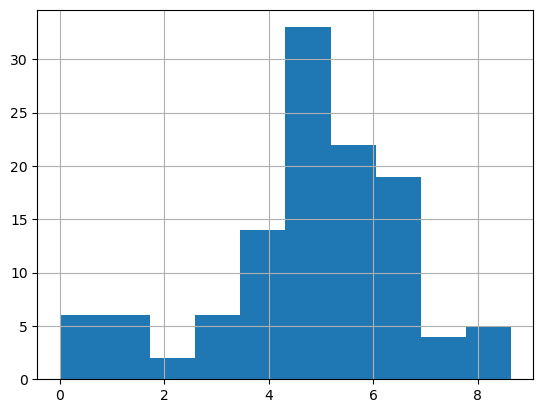

In [ ]:
exactly_bigram_amdf.filter(like='NEGany', axis=0).LRC.hist()


<Axes: >

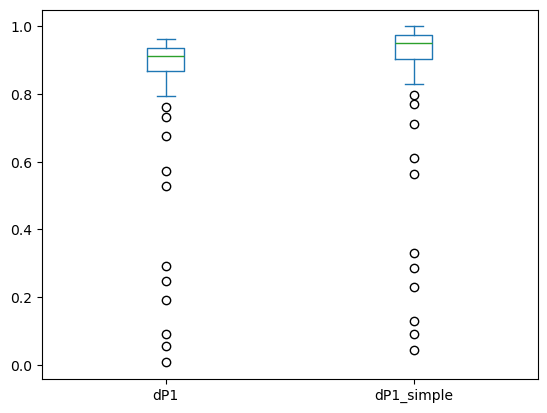

In [ ]:
exbi = exactly_bigram_amdf.filter(adjust_assoc_columns(FOCUS)).select_dtypes(include='number')
(exbi).filter(regex=r'dP1').filter(like='NEGany', axis=0).plot(kind = 'box')

<Axes: >

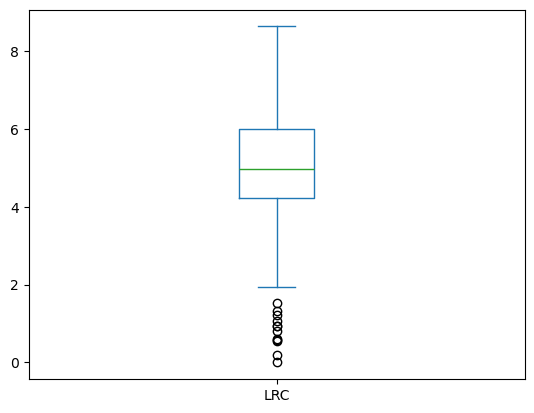

In [ ]:
exbi.LRC.filter(like='NEGany', axis=0).plot(kind = 'box')


<Axes: >

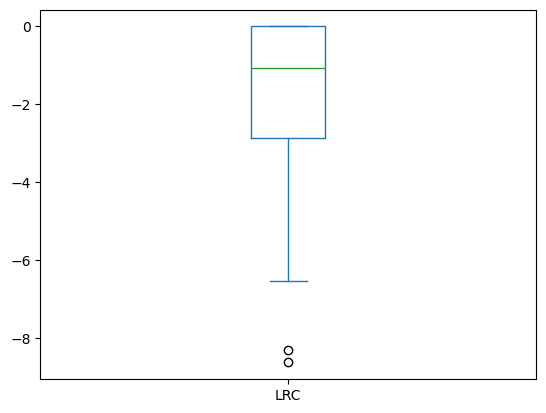

In [ ]:
exbi.LRC.filter(like='COM', axis=0).plot(kind = 'box')

In [ ]:
all_neg_lean_bigrams = exactly_bigram_amdf.loc[(exactly_bigram_amdf.LRC>1) & (exactly_bigram_amdf.dP1 > 0.1), :].filter(like="NEG", axis=0)
e_describe(all_neg_lean_bigrams.filter(adjust_assoc_columns(FOCUS)).select_dtypes(include='number')).T


/home/arh234/anaconda3/envs/dev-sanpi/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:385: RuntimeWarning: invalid value encountered in cast
  new_result = trans(result).astype(dtype)


,f,dP1,dP2,deltaP_max,dP1_simple,...,f1,f2,exp_f,unexp_f,adj_total
unique_forms,109,109,109,109,109,...,109,109,109,109,109
mean,258,1,0,1,1,...,"3,199,273",287,11,247,"188,091"
std,873,0,0,0,0,...,"281,260",920,34,839,"259,933"
min,50,0,0,0,0,...,"289,770",52,2,48,"6,973"
25%,73,1,0,1,1,...,"3,226,213",78,3,69,"42,859"
median,100,1,0,1,1,...,"3,226,213",108,4,96,"94,864"
75%,169,1,0,1,1,...,"3,226,213",179,7,161,"225,969"
max,"8,860",1,0,1,1,...,"3,226,213","9,301",348,"8,512","2,037,285"
total,"28,122",95,0,95,99,...,"348,720,774","31,311","1,189","26,933","20,501,944"
var_coeff,3,0,3,0,0,...,0,3,3,3,1


In [ ]:
all_neg_lean_bigrams.adj.nunique()

108

### _Least_ "Negative Leaning" _exactly_ bigrams

In [ ]:
exactly_bigram_amdf.loc[exactly_bigram_amdf.dP1<0.6, :].filter(like='NEG', axis=0).nsmallest(10, 'abs_LRC').filter(adjust_assoc_columns(FOCUS) + ['abs_LRC'])

,polarity,f,dP1,dP2,deltaP_max,...,l1,l2,adj,adj_total,abs_LRC
key,,,,,,,,,,,
NEGany~exactly_alike,NEG,134,0,0,0,...,NEGATED,exactly_alike,alike,"13,261",0
NEGmir~exactly_true,NEG,12,1,0,1,...,NEGMIR,exactly_true,true,"7,402",0
NEGmir~exactly_right,NEG,52,0,0,0,...,NEGMIR,exactly_right,right,"13,473",0
NEGmir~exactly_alike,NEG,40,0,0,0,...,NEGMIR,exactly_alike,alike,431,0
NEGmir~exactly_wrong,NEG,21,1,0,1,...,NEGMIR,exactly_wrong,wrong,"20,866",1
NEGany~exactly_equal,NEG,72,0,0,0,...,NEGATED,exactly_equal,equal,"47,099",1
NEGany~exactly_right,NEG,638,0,0,0,...,NEGATED,exactly_right,right,"204,572",1
NEGany~exactly_identical,NEG,81,0,0,0,...,NEGATED,exactly_identical,identical,"52,155",2
NEGany~exactly_wrong,NEG,178,0,0,0,...,NEGATED,exactly_wrong,wrong,"187,720",3


In [ ]:
am_for_blind = exactly_bigram_amdf.filter(regex='_'+r'|'.join(top_overall.l2), axis=0).filter(items=adjust_assoc_columns(FOCUS)).sort_values('LRC', ascending=False)
am_for_blind = interpret_polar_lrc(am_for_blind)
show_sample(am_for_blind, assoc=True, format='pipe')
print(am_for_blind[['polarity', 'significant', 'attract', 'promote', 'prohibit']].to_markdown(floatfmt=',.2f', intfmt=','))

for pol, pol_df in am_for_blind.groupby('polarity'): 
    print(f'\n#### {pol} Association')
    print(pol_df.filter(['f','dP1', 'LRC','promote', 'prohibit']).to_markdown(floatfmt=',.2f', intfmt=','))


| key                      | polarity   |     f |   dP1 |   dP2 |   deltaP_max |   dP1_simple |   dP2_simple |   LRC |         G2 |          N |         f1 |    f2 |    exp_f |   unexp_f | l1         | l2                | adj       |   adj_total | significant   | attract   | promote   | prohibit   |
|:-------------------------|:-----------|------:|------:|------:|-------------:|-------------:|-------------:|------:|-----------:|-----------:|-----------:|------:|---------:|----------:|:-----------|:------------------|:----------|------------:|:--------------|:----------|:----------|:-----------|
| NEGany~exactly_sure      | Negative   | 8,860 |  0.92 |  0.00 |         0.92 |         0.95 |         0.00 |  8.63 |  54,750.58 | 86,330,752 |  3,226,213 | 9,301 |   347.58 |  8,512.42 | NEGATED    | exactly_sure      | sure      |     844,981 | True          | True      | True      | False      |
| NEGany~exactly_ideal     | Negative   |   418 |  0.90 |  0.00 |         0.90 |         0.94 |  

In [ ]:
pd.set_option('display.float_format', '{:,.1f}'.format)
print(exactly_bigram_amdf.filter(like='O', axis=0)[['l1','adj','f', 'dP1','dP1_simple','LRC','G2']].round(1).sort_values([
    'LRC', 
    'dP1_simple',
    'f'
    ], ascending=False).to_markdown(floatfmt=',.1f'))

| key                    | l1         | adj        |    f |   dP1 |   dP1_simple |   LRC |        G2 |
|:-----------------------|:-----------|:-----------|-----:|------:|-------------:|------:|----------:|
| COM~exactly_alike      | COMPLEMENT | alike      | 2906 |  -0.0 |          1.0 |   0.0 |      -3.6 |
| COM~exactly_opposite   | COMPLEMENT | opposite   |  485 |   0.0 |          1.0 |   0.0 |       2.0 |
| COM~exactly_zero       | COMPLEMENT | zero       |  330 |  -0.0 |          1.0 |   0.0 |      -0.1 |
| COM~exactly_many       | COMPLEMENT | many       |   76 |  -0.0 |          1.0 |   0.0 |      -0.0 |
| COM~exactly_contrary   | COMPLEMENT | contrary   |   67 |   0.0 |          1.0 |   0.0 |       5.1 |
| COM~exactly_same       | COMPLEMENT | same       |  457 |  -0.0 |          0.9 |   0.0 |     -13.7 |
| COM~exactly_average    | COMPLEMENT | average    |   73 |  -0.0 |          0.9 |   0.0 |      -2.5 |
| COM~exactly_double     | COMPLEMENT | double     |   53 |  -0.0 |      

In [ ]:
exactly_bigram_amdf.filter(like='NEG', axis=0)[['l1','adj','f', 'dP1','dP1_simple','LRC','G2']].round(1).sort_values([
    'LRC', 
    'dP1_simple',
    'f'
    ], ascending=False)

,l1,adj,f,dP1,dP1_simple,LRC,G2
key,,,,,,,
NEGany~exactly_sure,NEGATED,sure,8860,0.9,1.0,8.6,"54,750.6"
NEGany~exactly_new,NEGATED,new,1378,0.9,1.0,8.5,"8,697.9"
NEGany~exactly_easy,NEGATED,easy,1069,0.9,1.0,8.4,"6,747.6"
NEGany~exactly_clear,NEGATED,clear,1759,0.9,1.0,8.3,"10,937.2"
NEGany~exactly_cheap,NEGATED,cheap,693,0.9,1.0,8.3,"4,443.3"
...,...,...,...,...,...,...,...
NEGany~exactly_obvious,NEGATED,obvious,50,1.0,1.0,0.2,328.7
NEGmir~exactly_new,NEGMIR,new,29,0.8,1.0,0.0,96.3
NEGmir~exactly_easy,NEGMIR,easy,20,0.8,1.0,0.0,72.2


## Text examples of top compositions (context-blind)

In [ ]:

def print_exactly_sample(example_df):    
    if example_df.index.name == 'hit_id': 
        example_df = example_df.reset_index() 
    example_df['hit_id'] = '`' + example_df.hit_id + '`'
    example_df = example_df.set_index('hit_id').filter(regex=r'token|bigram|trigger_lower|all_forms_lower|head')
    example_df = example_df.assign(
        token_str='*' + embolden(example_df.token_str, r'\b([Ee]xactly \w+)\b', mono=False).str.replace('``', '"') + '*',
        )
    example_df = example_df.sort_values(['trigger_lower', 'bigram_lower'] 
                      if 'trigger_lower' in example_df.columns else 'bigram_lower'
                      )[
                          [c for c in ['trigger_lower', 'bigram_lower', 'token_str', 'trigger_head'] if c in example_df.columns]]

    show_sample(example_df, format='pipe')

In [ ]:
neg_bigram_ids = full_not_exactly.bigram_id

In [ ]:
baseline_sample = pd.read_pickle(TOP_AM_DIR / 'top9adv_sample-9-hit-tables_2024-05-15.pkl.gz').filter(regex=r'bigram|token|text|lower|lemma')
baseline_sample = baseline_sample.loc[baseline_sample.adv_form_lower =='exactly', :]
positive_sample = baseline_sample.loc[~baseline_sample.index.isin(neg_bigram_ids),:]

show_sample(sample_pickle(data=positive_sample, regex=True, sample_size=8, quiet=True, print_sample=False))

+------------------------+-------------------------------------+---------------------------------------------------------+------------------+------------------+-----------------------+
| hit_id                 | text_window                         | token_str                                               | adv_form_lower   | adj_form_lower   | bigram_lower          |
+========================+=====================================+=========================================================+==================+==================+=======================+
| apw_eng_20001030_0204_ | , in the exactly right circumstance | shunned the spotlight , until now , as he heads toward  | exactly          | right            | exactly_right         |
| 3:19-20                | , could                             | a critical election that , in the exactly right         |                  |                  |                       |
|                        |                                     | circumstan

⚠️ There are a _lot_ of "no (two/NOUN)... exactly alike" cases that were not caught by `RBdirect` 😬
I think this may have influenced the association measures 🤔

In [ ]:
positive_sample = positive_sample.loc[
    ~positive_sample.token_str.str.lower()
    .str.contains(r"\bn[o'e]([tr]?|ver|thing|body|where|ne|ither)\b|\bain.?t\b|\b(without|seldom|(scarce|hard|bare|rare)ly)\b", 
                  regex=True),:].drop_duplicates('text_window')
show_sample(sample_pickle(data=positive_sample, regex=True, sample_size=8, quiet=True, print_sample=False))

+------------------------+------------------------------------+---------------------------------------------------------+------------------+------------------+-----------------+
| hit_id                 | text_window                        | token_str                                               | adv_form_lower   | adj_form_lower   | bigram_lower    |
+========================+====================================+=========================================================+==================+==================+=================+
| apw_eng_20090707_0580_ | it 's just exactly right .         | `` I think it 's just exactly right .                   | exactly          | right            | exactly_right   |
| 5:7-8                  |                                    |                                                         |                  |                  |                 |
+------------------------+------------------------------------+-----------------------------------------------

/tmp/ipykernel_11699/369532488.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ~positive_sample.token_str.str.lower()


In [ ]:
positive_sample['token_str'] = positive_sample.token_str.str.strip()

In [ ]:
len(positive_sample)

2141

In [ ]:
samples=[]
top_overall_bigram_lowers = top_overall.index.str.replace('~', '_').to_list()
for bigram in top_overall_bigram_lowers:
    bigram_examples = sample_pickle(data=positive_sample, filters=[f'bigram_lower=={bigram}'], sample_size=10, quiet=True, print_sample=False).reset_index()
    
    # bigram_examples = pd.read_csv(csv)
    # print(bigram)
    bigram_examples['hit_id'] = '`' + bigram_examples.hit_id + '`'

    bigram_sample = bigram_examples.set_index('hit_id').filter(regex=r'token|bigram')
    bigram_sample = bigram_sample.assign(
        token_str=embolden(bigram_sample.token_str, r'\b([Ee]xactly \w+)\b', mono=False),
        # text_window=embolden(bigram_examples.text_window, bigram_regex)
        )
    # show_sample(bigram_sample.head(1))
    samples.append(bigram_sample)
show_sample(pd.concat(samples), format='pipe')

| hit_id                                    | token_str                                                                                                                                                                                                                                                                                                                                                  | bigram_lower       |
|:------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------|
| `pcc_eng_06_034.4913_x0541706_07:10-11`   | This is a story of twin brothers who look  __exactly alike__  but extremely different .                                   

In [ ]:
other_positives = positive_sample.loc[~positive_sample.bigram_lower.isin(top_overall_bigram_lowers),:]


In [ ]:
other_examples = sample_pickle(data=other_positives, sample_size=60, quiet=True, print_sample=False, regex=True, 
                               filters=['token_str!=.*(re|[ai]s)nt ']).reset_index()
print_exactly_sample(other_examples)

| hit_id                                   | bigram_lower          | token_str                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
|:-----------------------------------------|:----------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
adj_limited_pmir = pmir_exactly.loc[~pmir_exactly.adj_form_lower.isin(['right','same','enough','identical','alike','comfortable','correct']),:].astype('string')
adj_limited_pmir.groupby('trigger_lower').adj_form_lower.value_counts().nlargest(10)

trigger_lower  adj_form_lower
all            opposite          3
always         equal             3
everything     true              3
               perfect           3
or             wrong             3
all            equal             2
everyone       equal             2
everything     different         2
or             equal             2
all            parallel          1
Name: count, dtype: int64

In [ ]:
for op in ('every', 'all', 'everyone', 'everybody', 'always'): 
    print(f'\n## *{op}*\n')
    if op in adj_limited_pmir.trigger_lower:
        univ_ex = sample_pickle(data=adj_limited_pmir, sample_size=30, 
                            quiet=True, print_sample=False, regex=True, 
                            filters=[f'trigger_lower==^{op}$', '']).reset_index()
        print_exactly_sample(univ_ex)


## *every*


## *all*


## *everyone*


## *everybody*


## *always*



In [ ]:
perpendicular = sample_pickle(data=other_positives, sample_size=60, quiet=True, print_sample=False, regex=True, 
                               filters=['token_str!=.*(re|[ai]s)nt ', 'bigram_lower==exactly_perpendicular']).reset_index()
    
perpendicular['hit_id'] = '`' + perpendicular.hit_id + '`'
perpendicular = perpendicular.set_index('hit_id').filter(regex=r'token|bigram')
perpendicular = perpendicular.assign(
    token_str='*' + embolden(perpendicular.token_str, r'\b([Ee]xactly \w+)\b', mono=False).str.replace('``', '"') + '*',
    ).sort_values('bigram_lower').reset_index()[['bigram_lower', 'token_str', 'hit_id']]

show_sample(perpendicular, format='pipe')

|    | bigram_lower          | token_str                                                                                                                                                                                                                                    | hit_id                                   |
|---:|:----------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------------------------------------|
|  0 | exactly_perpendicular | *This line is  __exactly perpendicular__  to the cycloid , and if you drew a circle around this point*                                                                                                                                       | `pcc_eng_06_058.9136_x0937134_099:4-5`   |
|  1 | exactly_perpendicular | *In this context , the rotatio

In [ ]:
pmir_exactly.head(3)

,bigram_id,token_str,pattern,category,adv_form,adj_form,text_window,trig_deprel,...,adv_index,adj_index,adv_form_lower,adj_form_lower,bigram_lower,all_forms_lower,trigger_lower,trigger_head
hit_id,,,,,,,,,,,,,,,,,
pcc_eng_13_045.7674_x0723903_18:08-0...,pcc_eng_13_045.7674_x0723903_18:09-10,"And you know what , they 're often e...",pos-mirror-R,POSmirror,exactly,right,"what , they 're often exactly right .",advmod,...,8,9,exactly,right,exactly_right,often_exactly_right,often,R
pcc_eng_13_079.2956_x1265427_12:10-1...,pcc_eng_13_079.2956_x1265427_12:12-13,This is MLS it is suposed to be fun ...,pos-mirror-R,POSmirror,exactly,funny,suposed to be fun or more exactly fu...,cc,...,11,12,exactly,funny,exactly_funny,or_exactly_funny,or,R
pcc_eng_13_102.5595_x1641011_50:3-4-5,pcc_eng_13_102.5595_x1641011_50:4-5,I was both exactly right and exactly...,pos-mirror-R,POSmirror,exactly,right,I was both exactly right and exactly...,advmod,...,3,4,exactly,right,exactly_right,both_exactly_right,both,R


In [ ]:
pmir_ex = sample_pickle(data=pmir_exactly, sample_size=40, quiet=True, print_sample=False, regex=True, 
                               filters=['token_str!=.*(re|[ai]s)nt ']).reset_index()


print_exactly_sample(pmir_ex)

| hit_id                                      | trigger_lower   | bigram_lower            | token_str                                                                                                                                                                                                                                                                                                                                                                                                                               | trigger_head   |
|:--------------------------------------------|:----------------|:------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
some_ex = pmir_exactly.loc[pmir_exactly.trigger_lower.str.startswith('some'), :].sample(10).reset_index()
print_exactly_sample(some_ex)

| hit_id                                      | trigger_lower   | bigram_lower       | token_str                                                                                                                                                                                                                                                                                                                                | trigger_head   |
|:--------------------------------------------|:----------------|:-------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:---------------|
| `apw_eng_20030511_0484_17:14-19-20`         | some            | exactly_identical  | *when researchers analyzed the antibodies ,

## Context-Blind AM

In [ ]:
adv_adj_AM = pd.read_pickle(RESULT_DIR.joinpath('assoc_df/adv_adj/RBXadj/extra/AdvAdj_frq-thrMIN-7.35f_min50x_extra.pkl.gz')
                                    )

In [ ]:
adv_adj_AM.columns

Index(['l1', 'l2', 'f', 'E11', 'am_log_likelihood', 'am_odds_ratio_disc', 'am_p1_given2', 'am_p2_given1',
       'am_p1_given2_simple', 'am_p2_given1_simple', 'f1', 'f2', 'N', 'Fyy(O11)', 'Fyn(O12)', 'Fny(O21)', 'Fnn(O22)',
       'Fy_(R1)', 'Fn_(R2)', 'F_y(C1)', 'F_n(C2)', 'E12', 'E21', 'E22', 't_score', 'dice', 'liddell',
       'mutual_information', 'deltaP_min', 'deltaP_max', 'deltaP_max_abs', 'deltaP_product', 'unexpected_f',
       'unexpected_ratio', 'expected_sqrt', 'unexpected_abs_sqrt', 'conservative_log_ratio',
       'conservative_log_ratio_001', 'conservative_log_ratio_01', 'conservative_log_ratio_05',
       'conservative_log_ratio_nc', 'conservative_log_ratio_dv', 'f_sqrt', 'f1_sqrt', 'f2_sqrt'],
      dtype='object')

In [ ]:
pd.set_option('display.float_format', '{:,.3f}'.format)
exactly_adj_AM = adjust_assoc_columns(adv_adj_AM.filter(like='exactly', axis=0).filter(FOCUS).set_index('l2'))
exactly_adj_AM.index.name = 'adj'


In [ ]:
exactly_adj_AM.info()

<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 145 entries, alike to many
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   f            145 non-null    int32   
 1   dP1          145 non-null    float32 
 2   dP1_simple   145 non-null    float32 
 3   dP2          145 non-null    float32 
 4   dP2_simple   145 non-null    float32 
 5   LRC          145 non-null    float32 
 6   G2           145 non-null    float64 
 7   odds_r_disc  145 non-null    float32 
 8   t            145 non-null    float32 
 9   MI           145 non-null    float32 
 10  f2           145 non-null    int32   
 11  exp_f        145 non-null    float64 
 12  unexp_f      145 non-null    float64 
 13  l1           145 non-null    category
dtypes: category(1), float32(8), float64(3), int32(2)
memory usage: 565.2 KB


In [ ]:
exactly_adj_AM['dP1mag'] = exactly_adj_AM.dP1.abs()
exactly_adj_AM['dP2mag'] = exactly_adj_AM.dP2.abs()
exactly_adj_AM['LRCmag'] = exactly_adj_AM.LRC.abs()

### Top Values

#### LRC

In [ ]:
exactly_adj_AM.nlargest(10,  ['LRCmag', 'LRC'])

,f,dP1,dP2,deltaP_max,dP1_simple,dP2_simple,LRC,G2,...,f1,f2,exp_f,unexp_f,l1,dP1mag,dP2mag,LRCmag
adj,,,,,,,,,,,,,,,,,
alike,3040,0.229,0.049,0.229,0.229,0.049,8.547,"29,939.315",...,61599,13261,9.462,"3,030.538",exactly,0.229,0.049,8.547
opposite,498,0.052,0.008,0.052,0.053,0.008,5.940,"3,337.273",...,61599,9404,6.710,491.290,exactly,0.052,0.008,5.940
right,6948,0.033,0.111,0.111,0.034,0.113,5.533,"41,085.552",...,61599,204572,145.967,"6,802.033",exactly,0.033,0.111,5.533
zero,344,0.029,0.005,0.029,0.030,0.006,5.018,"1,912.073",...,61599,11472,8.186,335.814,exactly,0.029,0.005,5.018
parallel,224,0.029,0.004,0.029,0.030,0.004,4.896,"1,238.345",...,61599,7577,5.406,218.594,exactly,0.029,0.004,4.896
analogous,118,0.031,0.002,0.031,0.032,0.002,4.809,669.528,...,61599,3706,2.644,115.356,exactly,0.031,0.002,4.809
perpendicular,52,0.035,0.001,0.035,0.036,0.001,4.628,307.747,...,61599,1444,1.030,50.970,exactly,0.035,0.001,4.628
stellar,177,0.025,0.003,0.025,0.025,0.003,4.606,925.076,...,61599,6973,4.975,172.025,exactly,0.025,0.003,4.606
sure,9301,0.010,0.141,0.141,0.011,0.151,3.889,"34,895.530",...,61599,844981,602.914,"8,698.086",exactly,0.010,0.141,3.889


#### $\Delta P(exactly|ADJ)$

In [ ]:
exactly_adj_AM.nlargest(10,['dP1mag','dP1'])

,f,dP1,dP2,deltaP_max,dP1_simple,dP2_simple,LRC,G2,...,f1,f2,exp_f,unexp_f,l1,dP1mag,dP2mag,LRCmag
adj,,,,,,,,,,,,,,,,,
alike,3040,0.229,0.049,0.229,0.229,0.049,8.547,"29,939.315",...,61599,13261,9.462,"3,030.538",exactly,0.229,0.049,8.547
opposite,498,0.052,0.008,0.052,0.053,0.008,5.940,"3,337.273",...,61599,9404,6.710,491.290,exactly,0.052,0.008,5.940
perpendicular,52,0.035,0.001,0.035,0.036,0.001,4.628,307.747,...,61599,1444,1.030,50.970,exactly,0.035,0.001,4.628
right,6948,0.033,0.111,0.111,0.034,0.113,5.533,"41,085.552",...,61599,204572,145.967,"6,802.033",exactly,0.033,0.111,5.533
analogous,118,0.031,0.002,0.031,0.032,0.002,4.809,669.528,...,61599,3706,2.644,115.356,exactly,0.031,0.002,4.809
zero,344,0.029,0.005,0.029,0.030,0.006,5.018,"1,912.073",...,61599,11472,8.186,335.814,exactly,0.029,0.005,5.018
parallel,224,0.029,0.004,0.029,0.030,0.004,4.896,"1,238.345",...,61599,7577,5.406,218.594,exactly,0.029,0.004,4.896
stellar,177,0.025,0.003,0.025,0.025,0.003,4.606,925.076,...,61599,6973,4.975,172.025,exactly,0.025,0.003,4.606
conducive,214,0.012,0.003,0.012,0.013,0.003,3.684,842.321,...,61599,16405,11.705,202.295,exactly,0.012,0.003,3.684


#### $P(exactly|ADJ)$

👉 or `f/f2`

In [ ]:
exactly_adj_AM.nlargest(10,['dP1_simple','dP1'])

,f,dP1,dP2,deltaP_max,dP1_simple,dP2_simple,LRC,G2,...,f1,f2,exp_f,unexp_f,l1,dP1mag,dP2mag,LRCmag
adj,,,,,,,,,,,,,,,,,
alike,3040,0.229,0.049,0.229,0.229,0.049,8.547,"29,939.315",...,61599,13261,9.462,"3,030.538",exactly,0.229,0.049,8.547
opposite,498,0.052,0.008,0.052,0.053,0.008,5.940,"3,337.273",...,61599,9404,6.710,491.290,exactly,0.052,0.008,5.940
perpendicular,52,0.035,0.001,0.035,0.036,0.001,4.628,307.747,...,61599,1444,1.030,50.970,exactly,0.035,0.001,4.628
right,6948,0.033,0.111,0.111,0.034,0.113,5.533,"41,085.552",...,61599,204572,145.967,"6,802.033",exactly,0.033,0.111,5.533
analogous,118,0.031,0.002,0.031,0.032,0.002,4.809,669.528,...,61599,3706,2.644,115.356,exactly,0.031,0.002,4.809
zero,344,0.029,0.005,0.029,0.030,0.006,5.018,"1,912.073",...,61599,11472,8.186,335.814,exactly,0.029,0.005,5.018
parallel,224,0.029,0.004,0.029,0.030,0.004,4.896,"1,238.345",...,61599,7577,5.406,218.594,exactly,0.029,0.004,4.896
stellar,177,0.025,0.003,0.025,0.025,0.003,4.606,925.076,...,61599,6973,4.975,172.025,exactly,0.025,0.003,4.606
conducive,214,0.012,0.003,0.012,0.013,0.003,3.684,842.321,...,61599,16405,11.705,202.295,exactly,0.012,0.003,3.684


#### $\Delta P(ADJ|exactly)$

In [ ]:
exactly_adj_AM.nlargest(10,['dP2mag','dP2'])

,f,dP1,dP2,deltaP_max,dP1_simple,dP2_simple,LRC,G2,...,f1,f2,exp_f,unexp_f,l1,dP1mag,dP2mag,LRCmag
adj,,,,,,,,,,,,,,,,,
sure,9301,0.010,0.141,0.141,0.011,0.151,3.889,"34,895.530",...,61599,844981,602.914,"8,698.086",exactly,0.010,0.141,3.889
right,6948,0.033,0.111,0.111,0.034,0.113,5.533,"41,085.552",...,61599,204572,145.967,"6,802.033",exactly,0.033,0.111,5.533
alike,3040,0.229,0.049,0.229,0.229,0.049,8.547,"29,939.315",...,61599,13261,9.462,"3,030.538",exactly,0.229,0.049,8.547
many,79,-0.001,-0.024,-0.001,0.000,0.001,-3.461,"-2,565.035",...,61599,2212989,"1,579.019","-1,500.019",exactly,0.001,0.024,3.461
true,1740,0.004,0.024,0.024,0.005,0.028,2.629,"3,826.531",...,61599,348994,249.015,"1,490.985",exactly,0.004,0.024,2.629
clear,1835,0.003,0.024,0.024,0.004,0.030,2.217,"3,147.965",...,61599,491108,350.417,"1,484.583",exactly,0.003,0.024,2.217
much,72,-0.001,-0.019,-0.001,0.000,0.001,-3.239,"-2,005.566",...,61599,1778739,"1,269.172","-1,197.172",exactly,0.001,0.019,3.239
new,1418,0.004,0.019,0.019,0.004,0.023,2.433,"2,817.695",...,61599,321311,229.263,"1,188.737",exactly,0.004,0.019,2.433
good,309,-0.001,-0.019,-0.001,0.000,0.005,-1.800,"-1,354.639",...,61599,2037285,"1,453.650","-1,144.650",exactly,0.001,0.019,1.800


#### $P(ADJ|exactly)$

👉 or `f/f1`

In [ ]:
exactly_adj_AM.nlargest(10,['dP2_simple','dP2'])

,f,dP1,dP2,deltaP_max,dP1_simple,dP2_simple,LRC,G2,...,f1,f2,exp_f,unexp_f,l1,dP1mag,dP2mag,LRCmag
adj,,,,,,,,,,,,,,,,,
sure,9301,0.010,0.141,0.141,0.011,0.151,3.889,"34,895.530",...,61599,844981,602.914,"8,698.086",exactly,0.010,0.141,3.889
right,6948,0.033,0.111,0.111,0.034,0.113,5.533,"41,085.552",...,61599,204572,145.967,"6,802.033",exactly,0.033,0.111,5.533
alike,3040,0.229,0.049,0.229,0.229,0.049,8.547,"29,939.315",...,61599,13261,9.462,"3,030.538",exactly,0.229,0.049,8.547
clear,1835,0.003,0.024,0.024,0.004,0.030,2.217,"3,147.965",...,61599,491108,350.417,"1,484.583",exactly,0.003,0.024,2.217
true,1740,0.004,0.024,0.024,0.005,0.028,2.629,"3,826.531",...,61599,348994,249.015,"1,490.985",exactly,0.004,0.024,2.629
new,1418,0.004,0.019,0.019,0.004,0.023,2.433,"2,817.695",...,61599,321311,229.263,"1,188.737",exactly,0.004,0.019,2.433
easy,1100,0.001,0.009,0.009,0.001,0.018,0.771,429.593,...,61599,771307,550.345,549.655,exactly,0.001,0.009,0.771
correct,788,0.009,0.012,0.012,0.010,0.013,3.560,"2,723.359",...,61599,78240,55.826,732.174,exactly,0.009,0.012,3.560
cheap,704,0.008,0.010,0.010,0.008,0.011,3.281,"2,195.835",...,61599,83765,59.768,644.232,exactly,0.008,0.010,3.281


#### $G^2$

In [ ]:
exactly_adj_AM.nlargest(10,['G2','LRC'])


,f,dP1,dP1_simple,dP2,dP2_simple,...,MI,f2,exp_f,unexp_f,l1
adj,,,,,,,,,,,
right,6948,0.033,0.034,0.111,0.113,...,1.678,204572,145.967,"6,802.033",exactly
sure,9301,0.010,0.011,0.141,0.151,...,1.188,844981,602.914,"8,698.086",exactly
alike,3040,0.229,0.229,0.049,0.049,...,2.507,13261,9.462,"3,030.538",exactly
true,1740,0.004,0.005,0.024,0.028,...,0.844,348994,249.015,"1,490.985",exactly
opposite,498,0.052,0.053,0.008,0.008,...,1.871,9404,6.710,491.290,exactly
clear,1835,0.003,0.004,0.024,0.030,...,0.719,491108,350.417,"1,484.583",exactly
new,1418,0.004,0.004,0.019,0.023,...,0.791,321311,229.263,"1,188.737",exactly
correct,788,0.009,0.010,0.012,0.013,...,1.150,78240,55.826,732.174,exactly
cheap,704,0.008,0.008,0.010,0.011,...,1.071,83765,59.768,644.232,exactly


#### Discounted Odds Ratio

In [ ]:
exactly_adj_AM.nlargest(10,['odds_r_disc','LRC'])


,f,dP1,dP1_simple,dP2,dP2_simple,...,MI,f2,exp_f,unexp_f,l1
adj,,,,,,,,,,,
alike,3040,0.229,0.229,0.049,0.049,...,2.507,13261,9.462,"3,030.538",exactly
opposite,498,0.052,0.053,0.008,0.008,...,1.871,9404,6.710,491.290,exactly
right,6948,0.033,0.034,0.111,0.113,...,1.678,204572,145.967,"6,802.033",exactly
perpendicular,52,0.035,0.036,0.001,0.001,...,1.703,1444,1.030,50.970,exactly
analogous,118,0.031,0.032,0.002,0.002,...,1.650,3706,2.644,115.356,exactly
zero,344,0.029,0.030,0.005,0.006,...,1.624,11472,8.186,335.814,exactly
parallel,224,0.029,0.030,0.004,0.004,...,1.617,7577,5.406,218.594,exactly
stellar,177,0.025,0.025,0.003,0.003,...,1.551,6973,4.975,172.025,exactly
conducive,214,0.012,0.013,0.003,0.003,...,1.262,16405,11.705,202.295,exactly


#### Mutual Information

In [ ]:
exactly_adj_AM.nlargest(10,['MI','LRC'])


,f,dP1,dP1_simple,dP2,dP2_simple,...,MI,f2,exp_f,unexp_f,l1
adj,,,,,,,,,,,
alike,3040,0.229,0.229,0.049,0.049,...,2.507,13261,9.462,"3,030.538",exactly
opposite,498,0.052,0.053,0.008,0.008,...,1.871,9404,6.710,491.290,exactly
perpendicular,52,0.035,0.036,0.001,0.001,...,1.703,1444,1.030,50.970,exactly
right,6948,0.033,0.034,0.111,0.113,...,1.678,204572,145.967,"6,802.033",exactly
analogous,118,0.031,0.032,0.002,0.002,...,1.650,3706,2.644,115.356,exactly
zero,344,0.029,0.030,0.005,0.006,...,1.624,11472,8.186,335.814,exactly
parallel,224,0.029,0.030,0.004,0.004,...,1.617,7577,5.406,218.594,exactly
stellar,177,0.025,0.025,0.003,0.003,...,1.551,6973,4.975,172.025,exactly
conducive,214,0.012,0.013,0.003,0.003,...,1.262,16405,11.705,202.295,exactly


#### $t$-score

In [ ]:
exactly_adj_AM.nlargest(10,['t','LRC'])

,f,dP1,dP1_simple,dP2,dP2_simple,...,MI,f2,exp_f,unexp_f,l1
adj,,,,,,,,,,,
sure,9301,0.010,0.011,0.141,0.151,...,1.188,844981,602.914,"8,698.086",exactly
right,6948,0.033,0.034,0.111,0.113,...,1.678,204572,145.967,"6,802.033",exactly
alike,3040,0.229,0.229,0.049,0.049,...,2.507,13261,9.462,"3,030.538",exactly
true,1740,0.004,0.005,0.024,0.028,...,0.844,348994,249.015,"1,490.985",exactly
clear,1835,0.003,0.004,0.024,0.030,...,0.719,491108,350.417,"1,484.583",exactly
new,1418,0.004,0.004,0.019,0.023,...,0.791,321311,229.263,"1,188.737",exactly
correct,788,0.009,0.010,0.012,0.013,...,1.150,78240,55.826,732.174,exactly
cheap,704,0.008,0.008,0.010,0.011,...,1.071,83765,59.768,644.232,exactly
equal,560,0.011,0.012,0.009,0.009,...,1.222,47099,33.606,526.394,exactly


In [ ]:
tops = [
    exactly_adj_AM.nlargest(10, ['t', 'LRC']),
    exactly_adj_AM.nlargest(10, ['MI', 'LRC']),
    exactly_adj_AM.nlargest(10, ['odds_r_disc', 'LRC']),
    exactly_adj_AM.nlargest(10, ['G2', 'LRC']),
    exactly_adj_AM.nlargest(10, ['dP2_simple', 'dP2']),
    exactly_adj_AM.nlargest(10, ['dP2', 'LRC']),
    exactly_adj_AM.nlargest(10, ['dP1_simple', 'dP1']),
    exactly_adj_AM.nlargest(10, ['dP1', 'LRC']),
    exactly_adj_AM.nlargest(10, ['LRC', 'dP1', 'dP2']),
]

blind_tops_df = pd.concat(tops).drop_duplicates().filter(['f','f2',
    'LRC',
    'dP1',
    'dP2',
    'G2',
    'dP1_simple',
    'dP2_simple',
    't', 
    'MI',
    'odds_r_disc',
    # 'dP1mag',
    # 'dP2mag',
    # 'LRCmag',
])
blind_tops_df = blind_tops_df.assign(dPmax=blind_tops_df[['dP1', 'dP2']].max(axis=1)).round(2).sort_values(['dPmax','LRC'], ascending=False)
blind_tops_df

,f,f2,LRC,dP1,dP2,...,dP2_simple,t,MI,odds_r_disc,dPmax
adj,,,,,,,,,,,
alike,3040,13261,8.550,0.230,0.050,...,0.050,54.960,2.510,2.640,0.230
sure,9301,844981,3.890,0.010,0.140,...,0.150,90.190,1.190,1.260,0.140
right,6948,204572,5.530,0.030,0.110,...,0.110,81.600,1.680,1.740,0.110
opposite,498,9404,5.940,0.050,0.010,...,0.010,22.020,1.870,1.900,0.050
perpendicular,52,1444,4.630,0.040,0.000,...,0.000,7.070,1.700,1.720,0.040
zero,344,11472,5.020,0.030,0.010,...,0.010,18.110,1.620,1.640,0.030
parallel,224,7577,4.900,0.030,0.000,...,0.000,14.610,1.620,1.630,0.030
analogous,118,3706,4.810,0.030,0.000,...,0.000,10.620,1.650,1.670,0.030
stellar,177,6973,4.610,0.020,0.000,...,0.000,12.930,1.550,1.560,0.020


In [ ]:
show_sample(blind_tops_df, format='pipe', n_dec=2, assoc=True)

| adj           |     f |      f2 |   LRC |   dP1 |   dP2 |        G2 |   dP1_simple |   dP2_simple |     t |   MI |   odds_r_disc |   dPmax |
|:--------------|------:|--------:|------:|------:|------:|----------:|-------------:|-------------:|------:|-----:|--------------:|--------:|
| alike         | 3,040 |  13,261 |  8.55 |  0.23 |  0.05 | 29,939.32 |         0.23 |         0.05 | 54.96 | 2.51 |          2.64 |    0.23 |
| sure          | 9,301 | 844,981 |  3.89 |  0.01 |  0.14 | 34,895.53 |         0.01 |         0.15 | 90.19 | 1.19 |          1.26 |    0.14 |
| right         | 6,948 | 204,572 |  5.53 |  0.03 |  0.11 | 41,085.55 |         0.03 |         0.11 | 81.60 | 1.68 |          1.74 |    0.11 |
| opposite      |   498 |   9,404 |  5.94 |  0.05 |  0.01 |  3,337.27 |         0.05 |         0.01 | 22.02 | 1.87 |          1.90 |    0.05 |
| perpendicular |    52 |   1,444 |  4.63 |  0.04 |  0.00 |    307.75 |         0.04 |         0.00 |  7.07 | 1.70 |          1.72 |    0.04 |

In [ ]:
mir_adv_adj_AM = pd.read_pickle(RESULT_DIR.joinpath('assoc_df/adv_adj/ANYmirror/extra/AdvAdj_frq-thrMIN-7.35f_min5x_extra.pkl.gz')
                                    ).filter(FOCUS)
mir_exactly_adj_AM = mir_adv_adj_AM.loc[mir_adv_adj_AM.l1=='exactly', :'unexpected_f']
mir_exactly_adj_AM.sort_values('deltaP_max')

,f,am_p1_given2,am_p2_given1,deltaP_max,deltaP_mean,am_p1_given2_simple,am_p2_given1_simple,conservative_log_ratio,am_log_likelihood,N,f1,f2,E11,unexpected_f
key,,,,,,,,,,,,,,
exactly~right,135,0.010,0.123,0.123,0.066,0.010,0.131,3.505,529.592,1761853,1034,13473,7.907,127.093
exactly~sure,148,0.015,0.138,0.138,0.076,0.015,0.143,4.143,701.235,1761853,1034,9744,5.719,142.281


### How much do adj in "most negative" bigrams associate with _exactly_ overall?

In [ ]:
most_neg

,f,dP1,LRC,G2,N,f1,f2,exp_f,unexp_f,l1,l2,adj,adj_total,adv,adv_total
key,,,,,,,,,,,,,,,
NEGany~exactly_shy,124,0.963,1.531,815.150,86330752,3226213,124,4.634,119.366,NEGATED,exactly_shy,shy,"50,956.000",exactly,"61,599.000"
NEGany~exactly_forthcoming,107,0.963,1.315,703.395,86330752,3226213,107,3.999,103.001,NEGATED,exactly_forthcoming,forthcoming,"11,270.000",exactly,"61,599.000"
NEGany~exactly_impressive,100,0.963,1.216,657.378,86330752,3226213,100,3.737,96.263,NEGATED,exactly_impressive,impressive,"195,739.000",exactly,"61,599.000"
NEGany~exactly_surprising,441,0.956,7.345,"2,863.349",86330752,3226213,444,16.592,424.408,NEGATED,exactly_surprising,surprising,"150,067.000",exactly,"61,599.000"
NEGany~exactly_practical,105,0.953,3.524,679.006,86330752,3226213,106,3.961,101.039,NEGATED,exactly_practical,practical,"67,263.000",exactly,"61,599.000"
NEGany~exactly_cheap,693,0.947,8.282,"4,443.270",86330752,3226213,704,26.309,666.691,NEGATED,exactly_cheap,cheap,"83,765.000",exactly,"61,599.000"
NEGany~exactly_easy,1069,0.934,8.366,"6,747.644",86330752,3226213,1100,41.107,"1,027.893",NEGATED,exactly_easy,easy,"771,307.000",exactly,"61,599.000"
NEGany~exactly_new,1378,0.934,8.536,"8,697.934",86330752,3226213,1418,52.991,"1,325.009",NEGATED,exactly_new,new,"321,311.000",exactly,"61,599.000"
NEGany~exactly_clear,1759,0.921,8.301,"10,937.156",86330752,3226213,1835,68.575,"1,690.425",NEGATED,exactly_clear,clear,"491,108.000",exactly,"61,599.000"


In [ ]:
blind_most_neg = exactly_adj_AM.filter(most_neg.adj.drop_duplicates(), axis=0)
blind_most_neg

,f,dP1,dP2,deltaP_max,dP1_simple,dP2_simple,LRC,G2,N,f1,f2,exp_f,unexp_f,dP1mag,dP2mag,LRCmag
adj,,,,,,,,,,,,,,,,
shy,124,0.00,0.00,0.00,0.00,0.00,1.08,129.25,86330753,61599,50956,36.36,87.64,0.00,0.00,1.08
forthcoming,107,0.01,0.00,0.01,0.01,0.00,3.00,356.99,86330753,61599,11270,8.04,98.96,0.01,0.00,3.00
impressive,100,-0.00,-0.00,-0.00,0.00,0.00,0.00,-12.55,86330753,61599,195739,139.66,-39.66,0.00,0.00,0.00
surprising,444,0.00,0.01,0.01,0.00,0.01,1.69,591.75,86330753,61599,150067,107.08,336.92,0.00,0.01,1.69
practical,106,0.00,0.00,0.00,0.00,0.00,0.40,52.07,86330753,61599,67263,47.99,58.01,0.00,0.00,0.40
cheap,704,0.01,0.01,0.01,0.01,0.01,3.28,"2,195.84",86330753,61599,83765,59.77,644.23,0.01,0.01,3.28
easy,1100,0.00,0.01,0.01,0.00,0.02,0.77,429.59,86330753,61599,771307,550.35,549.65,0.00,0.01,0.77
new,1418,0.00,0.02,0.02,0.00,0.02,2.43,"2,817.70",86330753,61599,321311,229.26,"1,188.74",0.00,0.02,2.43
clear,1835,0.00,0.02,0.02,0.00,0.03,2.22,"3,147.96",86330753,61599,491108,350.42,"1,484.58",0.00,0.02,2.22


### How much do ADJ in "most negative" bigrams associate with NEG env _independent of "exactly"_? 

In [ ]:
from source.utils import colors

<Axes: xlabel='adj'>

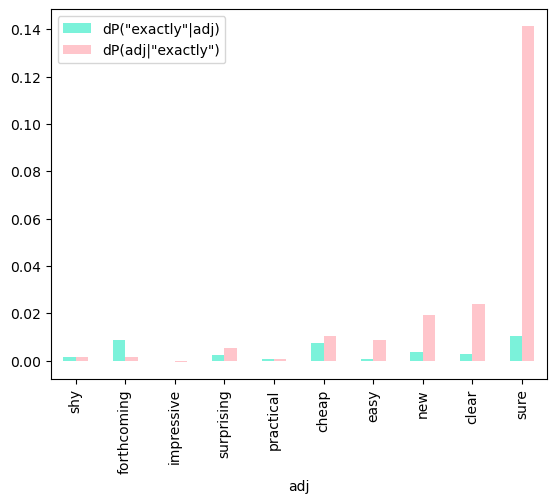

In [ ]:
blind_most_neg[['dP1','dP2']].rename(columns={'dP1': 'dP("exactly"|adj)', 
                                              'dP2': 'dP(adj|"exactly")'}
                                     ).plot(kind='bar', 
                                            colormap= colors.mcm['lisa_frank'])

<Axes: ylabel='adj'>

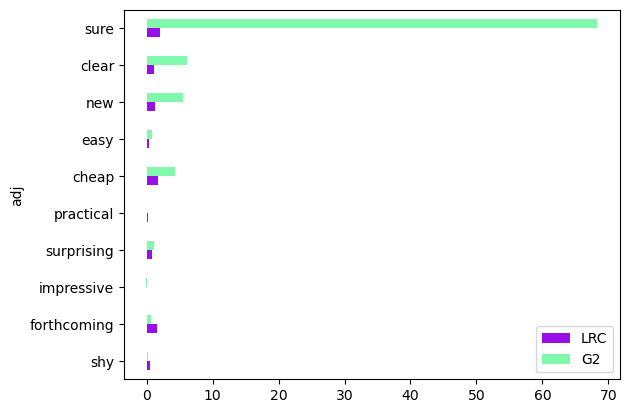

In [ ]:
xdf = blind_most_neg.filter(['LRC', 'G2'])
# xdf.assign(G2=xdf.G2/xdf.G2.mean()).plot(kind='bar', colormap=colors.mcm['easter'])
(xdf/xdf.median()).plot(kind='barh', colormap=colors.mcm['violet_seafoam'])

<Axes: ylabel='adj'>

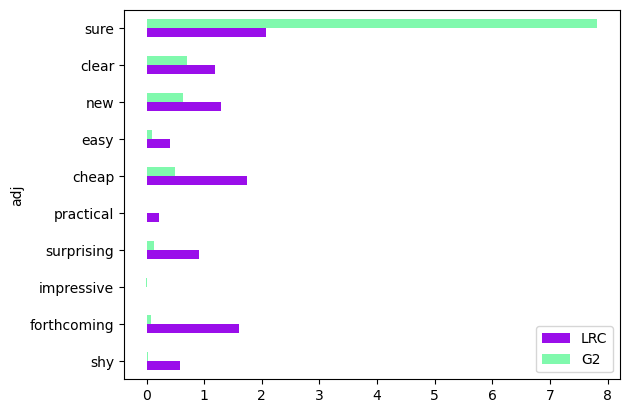

In [ ]:
(xdf/xdf.mean()).plot(kind='barh', colormap=colors.mcm['violet_seafoam_dark'])


array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>], dtype=object)

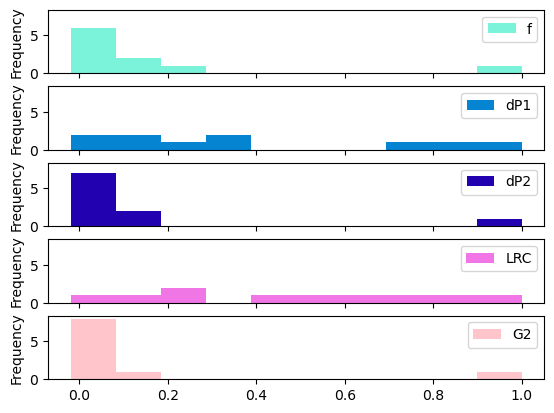

In [ ]:
xdf = blind_most_neg.filter(['f', 'dP1', 'dP2','LRC', 'G2' ])
(xdf/xdf.max()).plot(kind='hist', subplots=True, sharex=True, sharey=True, colormap=colors.mcm['lisa_frank'])

In [ ]:
from source.utils.dataframes import enhance_descrip as e_describe
e_describe(blind_most_neg.filter(regex=r'^dP|LRC|G')).loc[:, 'mean':'max']


,mean,std,min,25%,median,75%,max
dP1,0.00,0.00,-0.00,0.00,0.00,0.00,0.01
dP2,0.00,0.00,-0.00,0.00,0.00,0.00,0.14
dP1_simple,0.00,0.00,0.00,0.00,0.00,0.00,0.01
dP2_simple,0.00,0.00,0.00,0.00,0.00,0.00,0.15
LRC,1.90,1.30,0.00,0.80,2.00,2.90,3.89
G2,"4,460.40","10,760.50",-12.55,186.20,510.70,"2,662.20","34,895.53"
dP1mag,0.00,0.00,0.00,0.00,0.00,0.00,0.01
dP2mag,0.00,0.00,0.00,0.00,0.00,0.00,0.14
LRCmag,1.90,1.30,0.00,0.80,2.00,2.90,3.89


In [ ]:
e_describe(blind_most_neg.filter(regex=r'^dP|LRC|G')).loc[:,'var_coeff':]

,var_coeff,range,IQ_range,Q_disper,MAD,upper_fence,lower_fence
dP1,1.00,0.01,0.00,0.00,0.00,0.00,-0.00
dP2,2.00,0.14,0.00,0.00,0.00,0.00,-0.00
dP1_simple,0.80,0.01,0.00,0.00,0.00,0.00,-0.00
dP2_simple,1.80,0.15,0.00,0.00,0.00,0.10,-0.00
LRC,0.70,3.89,2.00,0.40,1.10,5.90,-2.20
G2,2.40,"34,908.08","2,476.00",0.90,490.90,"6,376.30","-3,527.90"
dP1mag,0.90,0.01,0.00,0.00,0.00,0.00,-0.00
dP2mag,2.00,0.14,0.00,0.00,0.00,0.00,-0.00
LRCmag,0.70,3.89,2.00,0.40,1.10,5.90,-2.20


### What are the context associations for bigrams containing context-blind associated adj?

In [ ]:
top_overall

,f,exp_f,unexp_f,dP1,LRC,G2,N,f1,f2,l1,l2
key,,,,,,,,,,,
exactly~alike,3040,9.46,"3,030.54",0.23,8.55,"29,939.32",86330753,61599,13261,exactly,alike
exactly~opposite,498,6.71,491.29,0.05,5.94,"3,337.27",86330753,61599,9404,exactly,opposite
exactly~right,6948,145.97,"6,802.03",0.03,5.53,"41,085.55",86330753,61599,204572,exactly,right
exactly~zero,344,8.19,335.81,0.03,5.02,"1,912.07",86330753,61599,11472,exactly,zero
exactly~parallel,224,5.41,218.59,0.03,4.90,"1,238.35",86330753,61599,7577,exactly,parallel
exactly~sure,9301,602.91,"8,698.09",0.01,3.89,"34,895.53",86330753,61599,844981,exactly,sure
exactly~equal,560,33.61,526.39,0.01,3.75,"2,108.45",86330753,61599,47099,exactly,equal
exactly~conducive,214,11.71,202.29,0.01,3.68,842.32,86330753,61599,16405,exactly,conducive
exactly~correct,788,55.83,732.17,0.01,3.56,"2,723.36",86330753,61599,78240,exactly,correct


In [ ]:
for adj, d in exactly_bigram_amdf.loc[exactly_bigram_amdf.adj.isin(top_overall.l2)].filter(adjust_assoc_columns(FOCUS) + ['polarity']).groupby('adj'):
    print(f'\n#### "{adj}"\n')
    # print(d.sort_values(['dP1', 'LRC'], ascending=False).T)
    show_sample(d.set_index('l1')[['dP1_simple', 'dP1', 'LRC', 'G2', 'l2']].sort_values(
        ['dP1', 'LRC'], ascending=False), assoc=True, format='pipe', n_dec=3)
    print()
    show_sample(d.filter(set(adjust_assoc_columns(FOCUS)) - {'dP2', 'deltaP_max', 'dP2_simple', 'l2', 'l1', 'adj'}).sort_values(
        ['dP1', 'LRC'], ascending=False).T, format='pipe', n_dec=3)


#### "alike"

| l1         |   dP1_simple |    dP1 |    LRC |      G2 | l2            |
|:-----------|-------------:|-------:|-------:|--------:|:--------------|
| NEGMIR     |        0.465 |  0.301 |  0.491 |  42.134 | exactly_alike |
| NEGATED    |        0.044 |  0.007 |  0.000 |   3.602 | exactly_alike |
| COMPLEMENT |        0.956 | -0.007 |  0.000 |  -3.570 | exactly_alike |
| POSMIR     |        0.535 | -0.301 | -0.491 | -42.124 | exactly_alike |



ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
pd.set_option('display.float_format', '{:,.2f}'.format)

In [ ]:
am_selection = pd.concat(d[['polarity','l1','dP1_simple', 'dP1', 'LRC', 'G2', 'l2', 'f']].set_index(['l2','polarity','l1']).sort_values(
        ['dP1', 'LRC'], ascending=False) 
          for adj, d in exactly_bigram_amdf.loc[exactly_bigram_amdf.adj.isin(top_overall.l2)].filter(adjust_assoc_columns(FOCUS)).groupby('adj'))
am_selection.loc[(am_selection.LRC.abs() > 1) & (am_selection.dP1.abs() > 0.1), :]

dP1_simple   dP1   LRC         G2     f
l2                polarity l1                                                 
exactly_conducive NEG      NEGATED           0.97  0.93  6.56   1,313.09   208
exactly_correct   NEG      NEGATED           0.33  0.29  3.06     744.93   259
                  POS      COMPLEMENT        0.67 -0.29 -3.06    -744.56   529
exactly_ideal     NEG      NEGATED           0.94  0.90  7.08   2,546.29   418
exactly_parallel  POS      COMPLEMENT        0.80 -0.16 -1.39     -84.66   179
exactly_sure      NEG      NEGATED           0.95  0.92  8.63  54,750.58  8860
                           NEGMIR            1.00  0.84  1.89     534.35   148
                  POS      COMPLEMENT        0.05 -0.92 -8.63 -54,736.84   441

In [ ]:
print('\n**Significant** `env~bigram` AM values\n')
show_sample(am_selection.loc[(am_selection.LRC.abs() > 1) & (am_selection.dP1.abs() > 0.1), :].reset_index(), assoc=True, format='pipe')
print('\n~~Insignificant~~ `env~bigram` AM values\n')
show_sample(am_selection.loc[~((am_selection.LRC.abs() > 1) & (am_selection.dP1.abs() > 0.1)), :].reset_index(), assoc=True, format='pipe')


**Significant** `env~bigram` AM values

|    | l2                | polarity   | l1         |   dP1_simple |   dP1 |   LRC |         G2 |     f |
|---:|:------------------|:-----------|:-----------|-------------:|------:|------:|-----------:|------:|
|  0 | exactly_conducive | NEG        | NEGATED    |         0.97 |  0.93 |  6.56 |   1,313.09 |   208 |
|  1 | exactly_correct   | NEG        | NEGATED    |         0.33 |  0.29 |  3.06 |     744.93 |   259 |
|  2 | exactly_correct   | POS        | COMPLEMENT |         0.67 | -0.29 | -3.06 |    -744.56 |   529 |
|  3 | exactly_ideal     | NEG        | NEGATED    |         0.94 |  0.90 |  7.08 |   2,546.29 |   418 |
|  4 | exactly_parallel  | POS        | COMPLEMENT |         0.80 | -0.16 | -1.39 |     -84.66 |   179 |
|  5 | exactly_sure      | NEG        | NEGATED    |         0.95 |  0.92 |  8.63 |  54,750.58 | 8,860 |
|  6 | exactly_sure      | NEG        | NEGMIR     |         1.00 |  0.84 |  1.89 |     534.35 |   148 |
|  7 | exactly

| l2                | polarity   | l1         |   dP1_simple |   dP1 |   LRC |         G2 |     f |
|:------------------|:-----------|:-----------|-------------:|------:|------:|-----------:|------:|
| exactly_conducive | NEG        | NEGATED    |         0.97 |  0.93 |  6.56 |   1,313.09 |   208 |
| exactly_correct   | NEG        | NEGATED    |         0.33 |  0.29 |  3.06 |     744.93 |   259 |
| exactly_correct   | POS        | COMPLEMENT |         0.67 | -0.29 | -3.06 |    -744.56 |   529 |
| exactly_ideal     | NEG        | NEGATED    |         0.94 |  0.90 |  7.08 |   2,546.29 |   418 |
| exactly_parallel  | POS        | COMPLEMENT |         0.80 | -0.16 | -1.39 |     -84.66 |   179 |
| exactly_sure      | NEG        | NEGATED    |         0.95 |  0.92 |  8.63 |  54,750.58 | 8,860 |
| exactly_sure      | NEG        | NEGMIR     |         1.00 |  0.84 |  1.89 |     534.35 |   148 |
| exactly_sure      | POS        | COMPLEMENT |         0.05 | -0.92 | -8.63 | -54,736.84 |   441 |

In [ ]:
pd.concat(d.set_index('l1')[['dP1_simple', 'dP1', 'LRC', 'G2', 'l2', 'f']].convert_dtypes().sort_values(
        ['dP1_simple','dP1'], ascending=False) 
          for adj, d in exactly_bigram_amdf.loc[exactly_bigram_amdf.adj.isin(top_overall.l2)].filter(adjust_assoc_columns(FOCUS)).groupby('adj'))

,dP1_simple,dP1,LRC,G2,l2,f
l1,,,,,,
COMPLEMENT,0.96,-0.01,0.00,-3.57,exactly_alike,2906
POSMIR,0.53,-0.30,-0.49,-42.12,exactly_alike,46
NEGMIR,0.47,0.30,0.49,42.13,exactly_alike,40
NEGATED,0.04,0.01,0.00,3.60,exactly_alike,134
NEGATED,0.97,0.93,6.56,"1,313.09",exactly_conducive,208
COMPLEMENT,0.67,-0.29,-3.06,-744.56,exactly_correct,529
NEGATED,0.33,0.29,3.06,744.93,exactly_correct,259
COMPLEMENT,0.87,-0.09,-0.94,-80.70,exactly_equal,488
POSMIR,0.77,-0.07,0.00,-0.38,exactly_equal,10


In [ ]:
pd.concat(d.set_index(['l2', 'l1'])[['f', 'dP1_simple', 'dP1', 'LRC', 'G2']].sort_values(
        ['dP1_simple','dP1'], ascending=False) 
          for adj, d in exactly_bigram_amdf.loc[exactly_bigram_amdf.adj.isin(top_overall.l2)].filter(adjust_assoc_columns(FOCUS)).groupby('adj'))

f  dP1_simple   dP1   LRC         G2
l2                l1                                                 
exactly_alike     COMPLEMENT  2906        0.96 -0.01  0.00      -3.57
                  POSMIR        46        0.53 -0.30 -0.49     -42.12
                  NEGMIR        40        0.47  0.30  0.49      42.13
                  NEGATED      134        0.04  0.01  0.00       3.60
exactly_conducive NEGATED      208        0.97  0.93  6.56   1,313.09
exactly_correct   COMPLEMENT   529        0.67 -0.29 -3.06    -744.56
                  NEGATED      259        0.33  0.29  3.06     744.93
exactly_equal     COMPLEMENT   488        0.87 -0.09 -0.94     -80.70
                  POSMIR        10        0.77 -0.07  0.00      -0.38
                  NEGATED       72        0.13  0.09  0.94      80.78
exactly_ideal     NEGATED      418        0.94  0.90  7.08   2,546.29
exactly_opposite  COMPLEMENT   485        0.97  0.01  0.00       1.97
exactly_parallel  COMPLEMENT   179        0.80 -0.16 -1.39     -84.66
exactly_right     COMPLEMENT  6310        0.91 -0.05 -1.05    -411.68
                  POSMIR        83        0.61 -0.22 -0.32     -37.58
                  NEGMIR        52        0.39  0.22  0.32      37.59
                  NEGATED      638        0.09  0.05  1.06     412.29
exactly_same      COMPLEMENT   457        0.93 -0.04  0.00     -13.71
exactly_sure      NEGMIR       148        1.00  0.84  1.89     534.35
                  NEGATED     8860        0.95  0.92  8.63  54,750.58
                  COMPLEMENT   441        0.05 -0.92 -8.63 -54,736.84
exactly_zero      COMPLEMENT   330        0.96 -0.00  0.00      -0.10